In [1]:
import torch
from PIL import Image
import requests
import torchvision.transforms as T
import matplotlib.pyplot as plt
from collections import defaultdict
import torch.nn.functional as F
import numpy as np
from skimage.measure import find_contours

from matplotlib import patches,  lines
from matplotlib.patches import Polygon

torch.set_grad_enabled(False);

In [2]:
%matplotlib notebook
%matplotlib inline

VQA_PATH='/Data_Storage/Rui_Data_Space/multimodal/VQA'
GQA_PATH='/Data_Storage/Rui_Data_Space/multimodal/GQA'

import pandas as pd
import json
import pickle as pkl
import numpy as np
import h5py
import random
from PIL import Image
import IPython.display as display
from collections import defaultdict
import os

import matplotlib.pyplot as plt
import torch

def load_pkl(path):
    data=pkl.load(open(path,'rb'))
    return data

def load_json(path):
    data=json.load(open(path,'r'))
    return data

In [4]:
val_all=load_json(os.path.join(VQA_PATH,'scenes','val_all.json'))
print ('Length of testing data:',len(val_all))

Length of testing data: 214354


In [5]:
q_type_counter=defaultdict(int)

number_q={}
for i,row in enumerate(val_all):
    if row['ans_type']!='other':
        continue
    number_q[row['idx']]={
        'question':row['question'],
        'img_id':row['img_id'],
        'answer':row['answer'],
        'scores':row['scores'],
        'q_type':row['q_type'],
        'ans_type':row['ans_type']
    }    
    q_type_counter[row['q_type']]+=1
print (q_type_counter)
print (len(number_q))

defaultdict(<class 'int'>, {'none of the above': 4097, 'what are the': 3203, 'what is': 6281, 'what': 15042, 'what is the man': 2660, 'what does the': 1884, 'why': 1430, 'why is the': 513, 'what color is the': 14060, 'what is the': 10592, 'which': 2370, 'what kind of': 5836, 'what color are the': 3118, 'does the': 130, 'where is the': 3711, 'what type of': 4036, 'what is the color of the': 826, 'what is on the': 2170, 'who is': 1067, 'what is this': 1689, 'how': 1544, 'what is in the': 1733, 'what are': 1553, 'what sport is': 1086, 'what is the person': 900, 'where are the': 1313, 'are these': 217, 'is this a': 570, 'what brand': 933, 'what color is': 1335, 'what is the woman': 853, 'what room is': 762, 'what color': 1428, 'is the': 1748, 'what time': 616, 'is the man': 137, 'what animal is': 831, 'what is the name': 766, 'is it': 322, 'are the': 435, 'how many': 142, 'is that a': 81, 'is this person': 50, 'is this an': 55, 'is this': 685, 'is he': 44, 'is the woman': 54, 'are': 46, 'a

In [18]:
qid_to_prompts={}

with open('../clip_vqa/other_prompt.txt') as number:
    for line in number:
        line = line.strip().split('\t')
        qid, quest, prompt = line[0], line[1].lower(), line[2]
        qid_to_prompts[qid] = {
            'prompt':prompt,
            'labels':None
        }
        
print (len(qid_to_prompts))
names=list(qid_to_prompts.keys())#<mask> token in the prompt

105600


In [8]:
names=list(qid_to_prompts.keys())
print (len(names))

105600


In [21]:
with open('../clip_vqa/other_filtered_T5_large.json') as other:
    for line in other:
        data = json.loads(line.strip())
        qid_to_prompts[data['qid']]['labels'] =data['labels']

In [28]:
vis=0
random.shuffle(names)
for name in names:
    info=number_q[name]
    if info['q_type'] in ['what color is the','what color is',
                          'what color are the','what is the color of the']:
        continue
    if vis>10:
        break
    vis+=1
    print(info['question'],info['q_type'])
    print (info['answer'])
    print('\t',qid_to_prompts[name]['prompt'])
    print('\t',qid_to_prompts[name]['labels'][:10],'\n')

What kind of product the truck is transporting? what kind of
['bottle water', 'water', 'water jugs', 'water bottles']
	 <mask> is transporting.
	 ['archery', 'artistic gymnastics', 'athletics', 'badminton', 'baseball', 'basketball', 'biking', 'bowling', 'boxing', 'cricket'] 

What are they doing? what are
['playing on wii', 'playing wii', 'having fun on wii', 'playing video game']
	 They are doing <mask>.
	 ['no', 'art', 'lots', 'school', 'electronics', 'real', 'listening', 'right', 'laundry', 'golf'] 

What kind of fruit is here? what kind of
['papaya', 'oranges, plums, kiwi', 'oranges', 'bananas oranges squash apples squash', 'oranges, mango', 'banana', 'seasonal', 'tropical']
	 Here is <mask>.
	 ['apple', 'apricot', 'avocado', 'banana', 'blackberry', 'blackcurrant', 'blueberry', 'boysenberry', 'cherry', 'coconut'] 

Why is a strap connected to the back of this surfboard? why
['to keep child with board', "for surfer's foot", 'balance', 'keep surfboard from floating away', 'to keep ch

In [29]:
color_parser=load_pkl(os.path.join(VQA_PATH,'parser-related/color_related.pkl'))
print (len(color_parser))

20768


In [31]:
vis=0
random.shuffle(names)
for name in names:
    info=number_q[name]
    if info['q_type'] not in ['what color is','what is the color of the',
                          'what color is the','what color are the',
                          'what color']:
        continue
    vis+=1
print ('color related',vis)#some what color are not in open-ended questions

color related 20752


In [60]:
import skimage
from skimage import io as skimage_io
from skimage import transform as skimage_transform

In [57]:
def get_vqa_feat(img_id):
    # Load example image:
    filename = os.path.join(VQA_PATH,'images/val2014',img_id)
    image_uint8 = skimage_io.imread(filename)
    image = image_uint8.astype(np.float32) / 255.0

    # Pad to square with gray pixels on bottom and right:
    h, w, _ = image.shape
    size = max(h, w)
    image_padded = np.pad(
        image, ((0, size - h), (0, size - w), (0, 0)), constant_values=0.5)

    # Resize to model input size:
    input_image = skimage.transform.resize(
        image_padded,
        (840, 840),
        anti_aliasing=True)
    return input_image

def transform_coord(bbox,img_id):
    im=Image.open(os.path.join(VQA_PATH,'images/val2014',img_id))
    width, height=im.size
    #width=val_graphs[img_id]['width']
    #height=val_graphs[img_id]['height']
    size = max(height, width)
    x=bbox[0]
    y=bbox[1]
    w=bbox[2]-bbox[0]
    h=bbox[3]-bbox[1]
    #print (bbox)
    return [(x+w/2)/size,(y+h/2)/size,w/size,h/size]

def generate_phrase_ground(img_id,cap,obj):
    im=Image.open(os.path.join(VQA_PATH,'images/val2014',img_id))
    try:
        scores,bboxs,labels=plot_inference(im, cap, plot=False)
    except:
        print ('Invalid caption generation for',img_id,obj,cap)
        scores=[torch.Tensor([0.99])]
        bboxs=[[0.5,0.5,0.99,0.99]]
        labels=[obj]
    if len(bboxs)==0:
        max_s=0.99
        valid_bbox=[0.5,0.5,0.99,0.99]
    else:
        # print (scores,bboxs)
        max_s,valid_bbox=preprocess_mdert_result(scores,bboxs,labels,obj,img_id)
    return max_s,valid_bbox

def get_cropped(bb,input_image,showing=False):
    width=bb[2]*840
    height=bb[3]*840
    xy=(bb[0]*840-width/2,bb[1]*840-height/2)
    h0=int(max(0,xy[1]))
    w0=int(max(0,xy[0]))
    h1=int(max(0,840-(height+xy[1])))
    w1=int(max(0,840-(width+xy[0])))
    cropped=skimage.util.crop(input_image,((h0,h1),(w0,w1),(0,0)), copy=False)
    trans_crop=Image.fromarray(np.uint8(cropped*255.0))
    if showing:
        display.display(trans_crop)
    return trans_crop

def preprocess_mdert_result(scores,bboxs,labels,obj,img_id):
    sf_s=[]
    sf_bbox=[]
    labels=[''.join(label.split(' ')) for label in labels]
    flag=False
    if obj in labels:
        flag=True
    #print (obj,labels)
    for i,label in enumerate(labels):
        if flag:
            if obj==label:
                sf_s.append(scores[i])
                sf_bbox.append(bboxs[i])
        else:
            if obj in label:
                sf_s.append(scores[i])
                sf_bbox.append(bboxs[i])
    #print (len(sf_s))
    if len(sf_bbox)==0:
        for i,label in enumerate(labels):
            sf_s.append(scores[i])
            sf_bbox.append(bboxs[i])
    max_s=max(sf_s)
    max_id=sf_s.index(max_s)
    return_bbox=sf_bbox[max_id]
    coord=transform_coord(return_bbox,img_id)
    return max_s.item(),coord
#only consider one bbox now

In [56]:
COLOR_CANDI=['black', 'blue', 'bronze', 'brown', 'beige', 'blond',
             'gold', 'gray', 'green', 'lime', 'orange', 'pink', 'purple', 
             'red', 'silver', 'teal', 'white', 'yellow']

In [62]:
with torch.no_grad():
    COLOR_FEAT = clip_model.encode_text(clip.tokenize(COLOR_CANDI).to(device))
COLOR_FEAT /= COLOR_FEAT.norm(dim=-1, keepdim=True)
print (COLOR_FEAT.shape)

torch.Size([18, 512])


In [64]:
def ans_color_ques(obj,img_id,showing=False):
    max_s,valid_bbox=generate_phrase_ground(img_id,obj,obj)
    img_feat=get_vqa_feat(img_id)
    trans_crop=get_cropped(valid_bbox,img_feat)
    if showing:
        display.display(trans_crop)
    with torch.no_grad():
        image_features = clip_model.encode_image(preprocess(trans_crop).unsqueeze(0).to(device))
    image_features /= image_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ COLOR_FEAT.T).softmax(dim=-1)
    values, indices = similarity.topk(2)
    #print (indices[0][0].item())
    ans=COLOR_CANDI[indices[0][0].item()]
    return ans

In [172]:
vis=0
random.shuffle(names)
for name in names:
    if vis>10:
        break
    info=number_q[name]
    if info['q_type'] not in ['what color is','what is the color of the',
                          'what color is the','what color are the',
                          'what color']:
        continue
    vis+=1
    print (info['question'])
    color_det=color_parser[name]
    if color_det['phrase'] is not None:
        obj='the '+color_det['word']
        first_det=color_det['phrase']
    else:
        obj='the '+color_det['word']
        first_det=None
    print ('\t',obj,info['answer'])
    img_id=info['img_id']
    img_id='COCO_val2014_'+img_id.zfill(12)+'.jpg'
    pred=ans_color_ques(obj,img_id,showing=True)
    print ('Prediction:',pred,'\n')
    
    #plot_inference(im,obj)
    
print ('color related',vis)#some what color are not in open-ended questions

What color is the stand?
	 the stand ['silver', 'stainless steel', 'white']
Prediction: silver 

What color is the mug?
	 the mug ['yellow', 'yellow with pink and purple flowers']
Prediction: green 

What color are the pants?
	 the pants ['no plants', 'white', 'do not know', "can't see pants"]
Prediction: silver 

What is the color of the shirt?
	 the shirt ['black']
Prediction: black 

What color is lit up on the street lights?
	 the street lights ['green']
Prediction: yellow 

What color is the batter's helmet?
	 the helmet ['black']
Prediction: orange 

What color is the fruit peel?
	 the fruit peel ['orange']
Prediction: yellow 

What color are the cat's eyes?
	 the eyes ['green', 'yellow', 'black and yellow']
Prediction: lime 

What color are the flower blossoms?
	 the flower blossoms ['yellow', 'green', 'white']
Prediction: green 

What color shirt is the person taking the picture wearing?
	 the shirt ['blue']
Prediction: green 

What color is the pasta?
	 the pasta ['orange', 'r

In [70]:
vis=0
random.shuffle(names)
acc={q:0.0 for q in q_type_counter}
counter={q:0.0 for q in q_type_counter}
invalid=[]
for name in names:
    #if vis>10:
    #   break
    info=number_q[name]
    if info['q_type'] not in ['what color is','what is the color of the',
                          'what color is the','what color are the',
                          'what color']:
        continue
    vis+=1
    #print (info['question'])
    color_det=color_parser[name]
    if color_det['phrase'] is not None:
        obj='the '+color_det['word']
        first_det=color_det['phrase']
    else:
        obj='the '+color_det['word']
        first_det=None
    #print ('\t',obj,info['answer'])
    img_id=info['img_id']
    img_id='COCO_val2014_'+img_id.zfill(12)+'.jpg'
    try:
        pred=ans_color_ques(obj,img_id)
    except:
        invalid.append(name)
    counter[info['q_type']]+=1
    if pred in info['answer']:
        score=info['scores'][info['answer'].index(pred)]
        acc[info['q_type']]+=score
    #print ('Prediction:',pred,'\n')
    if vis%500==0:
        print('Already finish:',vis,len(invalid))
        for q_t in counter:
            if counter[q_t]==0:
                continue
            print ('\tQuestion type:%s, Accuracy %.2f' % 
                   (q_t,acc[q_t]*100.0/counter[q_t]))
        print('\tAccuracy %.2f\n' % 
              (sum(acc.values())*100.0/sum(counter.values())))  

print ('Overall')
for q_t in counter:
    if counter[q_t]==0:
        continue
    print ('\tQuestion type:%s, Accuracy %.2f, Number of instance %d' % 
           (q_t,acc[q_t]*100.0/counter[q_t],counter[q_t]))
print('\tAccuracy %.2f' % 
      (sum(acc.values())*100.0/sum(counter.values())))  
print ('Invalid',len(invalid))
    
print ('color related',vis)#some what color are not in open-ended questions

Already finish: 500 0
	Question type:what color is the, Accuracy 36.76
	Question type:what color are the, Accuracy 42.14
	Question type:what is the color of the, Accuracy 25.83
	Question type:what color is, Accuracy 55.71
	Question type:what color, Accuracy 39.38
	Accuracy 38.48

Already finish: 1000 0
	Question type:what color is the, Accuracy 36.08
	Question type:what color are the, Accuracy 36.58
	Question type:what is the color of the, Accuracy 40.00
	Question type:what color is, Accuracy 50.65
	Question type:what color, Accuracy 36.13
	Accuracy 37.23

Already finish: 1500 0
	Question type:what color is the, Accuracy 36.92
	Question type:what color are the, Accuracy 35.75
	Question type:what is the color of the, Accuracy 36.90
	Question type:what color is, Accuracy 48.63
	Question type:what color, Accuracy 38.89
	Accuracy 37.60

Already finish: 2000 0
	Question type:what color is the, Accuracy 37.44
	Question type:what color are the, Accuracy 33.66
	Question type:what is the color 

Already finish: 13000 13
	Question type:what color is the, Accuracy 37.30
	Question type:what color are the, Accuracy 35.79
	Question type:what is the color of the, Accuracy 35.65
	Question type:what color is, Accuracy 43.73
	Question type:what color, Accuracy 31.15
	Accuracy 37.00

Already finish: 13500 13
	Question type:what color is the, Accuracy 37.24
	Question type:what color are the, Accuracy 35.96
	Question type:what is the color of the, Accuracy 35.07
	Question type:what color is, Accuracy 43.68
	Question type:what color, Accuracy 31.00
	Accuracy 36.94

Invalid caption generation for COCO_val2014_000000274219.jpg the tie the tie
Already finish: 14000 14
	Question type:what color is the, Accuracy 37.17
	Question type:what color are the, Accuracy 36.02
	Question type:what is the color of the, Accuracy 35.58
	Question type:what color is, Accuracy 43.97
	Question type:what color, Accuracy 31.97
	Accuracy 37.00

Already finish: 14500 14
	Question type:what color is the, Accuracy 37.

In [36]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_inference(im, caption, plot=True):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0).cuda()

    # propagate through the model
    memory_cache = model(img, [caption], encode_and_save=True)
    outputs = model(img, [caption], encode_and_save=False, memory_cache=memory_cache)
    #print (outputs['pred_logits'])

    # keep only predictions with 0.7+ confidence
    probas = 1 - outputs['pred_logits'].softmax(-1)[0, :, -1].cpu()
    keep = (probas > 0.7).cpu()

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'].cpu()[0, keep], im.size)

    # Extract the text spans predicted by each box
    positive_tokens = (outputs["pred_logits"].cpu()[0, keep].softmax(-1) > 0.1).nonzero().tolist()
    predicted_spans = defaultdict(str)
    for tok in positive_tokens:
        item, pos = tok
        if pos < 255:
            span = memory_cache["tokenized"].token_to_chars(0, pos)
            predicted_spans [item] += " " + caption[span.start:span.end]

    labels = [predicted_spans [k] for k in sorted(list(predicted_spans .keys()))]
    if plot:
        plot_results(im, probas[keep], bboxes_scaled, labels)
    return probas[keep], bboxes_scaled.tolist(), labels

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def plot_results(pil_img, scores, boxes, labels, masks=None):
    plt.figure(figsize=(16,10))
    np_image = np.array(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if masks is None:
        masks = [None for _ in range(len(scores))]
    assert len(scores) == len(boxes) == len(labels) == len(masks)
    for s, (xmin, ymin, xmax, ymax), l, mask, c in zip(scores, boxes.tolist(), labels, masks, colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{l}: {s:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15, bbox=dict(facecolor='white', alpha=0.8))

        if mask is None:
            continue
        np_image = apply_mask(np_image, mask, c)

        padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=c)
            ax.add_patch(p)


    plt.imshow(np_image)
    plt.axis('off')
    plt.show()


def add_res(results, ax, color='green'):
    #for tt in results.values():
    if True:
        bboxes = results['boxes']
        labels = results['labels']
        scores = results['scores']
        #keep = scores >= 0.0
        #bboxes = bboxes[keep].tolist()
        #labels = labels[keep].tolist()
        #scores = scores[keep].tolist()
    #print(torchvision.ops.box_iou(tt['boxes'].cpu().detach(), torch.as_tensor([[xmin, ymin, xmax, ymax]])))
    
    colors = ['purple', 'yellow', 'red', 'green', 'orange', 'pink']
    
    for i, (b, ll, ss) in enumerate(zip(bboxes, labels, scores)):
        ax.add_patch(plt.Rectangle((b[0], b[1]), b[2] - b[0], b[3] - b[1], fill=False, color=colors[i], linewidth=3))
        cls_name = ll if isinstance(ll,str) else CLASSES[ll]
        text = f'{cls_name}: {ss:.2f}'
        print(text)
        ax.text(b[0], b[1], text, fontsize=15, bbox=dict(facecolor='white', alpha=0.8))

In [38]:
import clip

CUDA_DEVICE=12
torch.cuda.set_device(CUDA_DEVICE)
device = torch.device("cuda:"+str(CUDA_DEVICE))
#the default ipykernel links to the first conda environment

model, postprocessor = torch.hub.load('ashkamath/mdetr:main', 'mdetr_efficientnetB5', pretrained=True, return_postprocessor=True)
model = model.to(device)
model.eval();

clip_model, preprocess = clip.load("ViT-B/32",device=device)

Using cache found in /root/.cache/torch/hub/ashkamath_mdetr_main
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


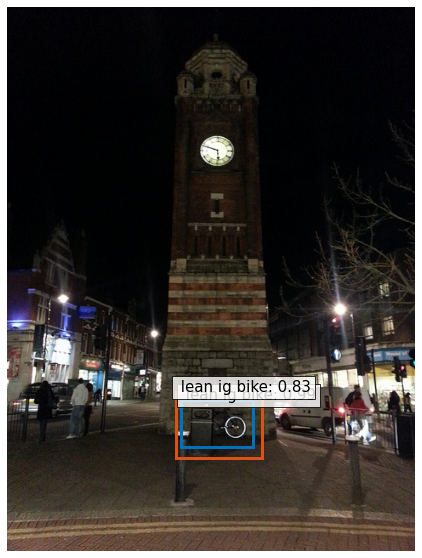

In [42]:
img_id='157756'
img_id='COCO_val2014_'+img_id.zfill(12)+'.jpg'
cap='leanig bike'
im=Image.open(os.path.join(VQA_PATH,'images/val2014',img_id))
scores,bboxs,labels=plot_inference(im, cap)

In [44]:
layout_info=load_pkl('../VQA_Zero-shot_decomposable/open_ended_layout_VQA.pkl')
print (len(layout_info))

84852


In [123]:
valid_ops=[
    'select',
    
    'select-select-and',
    'select-select-and-filter',
    'select-filter-select-and',
    
    'select-filter',
    
    'select-relocate-filter'#item
    'select-relocate-select-and-filter',#last select
    'select-relocate-filter-select-and',#last select
    'select-relocate-select-and',#last select
    'select-filter-relocate-select-and',#cap
    'select-relocate-relocate-select-and',#last select
]

In [202]:
def pred_all_open(parser,idx,ques,img_id):
    invalid=parser['invalid']
    if idx in or_det:
        pred=answer_or(idx,img_id)
    elif invalid:
        temp=qid_to_prompts[idx]['prompt']
        candi=qid_to_prompts[idx]['labels']
        pred=binary_matching(img_id,temp,candi)
    elif ques.startswith('why'):
        temp=qid_to_prompts[idx]['prompt']
        candi=qid_to_prompts[idx]['labels']
        pred=binary_matching(img_id,temp,candi)
    else:
        layout=parser['layout']
        pred=pred_decomp_open(idx,ques,img_id,layout)
    return pred

In [154]:
def binary_matching(img_id,temp,candidates):
    sents=[temp.replace('<mask>',c) for c in candidates]
    tokens=clip.tokenize(sents)
    im=Image.open(os.path.join(VQA_PATH,'images/val2014',img_id))
    with torch.no_grad():
        text_features=clip_model.encode_text(tokens.to(device))
        image_features = clip_model.encode_image(preprocess(im).unsqueeze(0).to(device))
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    #indices=torch.max(similarity,1)[1]
    #print (similarity,indices)
    #similarity=similarity.squeeze()
    values, indices = similarity.topk(2)
    #print (indices[0][0].item())
    #print (indices.shape)
    ans=candidates[indices[0][0].item()]
    return ans

In [136]:
def generate_cap(layout):
    words=[]
    ops='-'.join(step['operation'] for step in layout)
    if ops=='select-filter-filter':
        cap=' '.join([layout[2]['argument'][0],
                      layout[0]['argument'][0],
                      layout[1]['argument'][0]])
        obj=cap
    elif ops in ['select-filter-select-and','select-select-and'
                 'select-select-and-filter']:
        cap='the '+layout[0]['argument'][0]
        obj=cap
    else:
        flag=True
        obj=None
        for i in range(len(layout)):
            cur_idx=len(layout)-1-i
            cur=layout[cur_idx]
            cur_op=cur['operation']
            if cur_op=='and':
                continue
            cur_arg=cur['argument'][0]
            #print (cur_op,cur_arg,words)
            words.append(cur_arg)
            if cur_op=='select' and flag:
                flag=False
                obj=cur_arg
            if cur_op=='relocate':
                break
        if ops =='select-relocate-filter':
            words.insert(0,'item')
            obj='item'
        cap=' '.join(words)
        if ops=='select-filter-relocate-select-and':
            obj=cap
    return cap,obj

In [158]:
import inflect
stemmer = inflect.engine()

In [189]:
import enchant
en_dict=enchant.Dict("en_US")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [152]:
def ans_open_ques(valid_bbox,img_id,candidates,showing=False):
    img_feat=get_vqa_feat(img_id)
    trans_crop=get_cropped(valid_bbox,img_feat)
    if showing:
        display.display(trans_crop)
        
    with torch.no_grad():
        image_features = clip_model.encode_image(preprocess(trans_crop).unsqueeze(0).to(device))
        text_features = clip_model.encode_text(clip.tokenize(candidates).to(device))
    
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity.topk(2)
    ans=candidates[indices[0][0].item()]
    return ans

In [201]:
def pred_decomp_open(idx,ques,img_id,layout):
    ops='-'.join(step['operation'] for step in layout)
    if ops not in valid_ops:
        temp=qid_to_prompts[idx]['prompt']
        candi=qid_to_prompts[idx]['labels']
        pred=binary_matching(img_id,temp,candi)
    else:
        if len(layout)==1:
            cap='the '+layout[0]['argument'][0]
            obj=cap
        elif len(layout)==1:
            cap=' '.join([layout[0]['argument'][0],
                          layout[1]['argument'][0]])
            obj=cap
        else:
            cap,obj=generate_cap(layout)
        if number_q[name]['q_type'] in ['what room is']:
            valid_bbox=[0.5,0.5,0.99,0.99]#return the whole image
        else:
            max_s,valid_bbox=generate_phrase_ground(img_id,cap,obj)
        #print (cap,obj)
        candidates=qid_to_prompts[name]['labels']
        cap_list=[]
        for w in cap.split(' '):
            obj=stemmer.singular_noun(w)
            if obj==False:
                obj=w
            cap_list.append(obj)
        words=[]
        for w in candidates:
            if w in cap_list:
                continue
            if stemmer.singular_noun(w) in cap_list:
                continue
            words.append(w)
        pred=ans_open_ques(valid_bbox,img_id,words)
    return pred 

In [206]:
def answer_or(idx,img_id):
    parse=or_det[idx]
    sp_info=parse.split(';')
    if len(sp_info)==1:
        #no detected obj and attribute
        valid_bbox=[0.5,0.5,0.99,0.99]
        attr=sp_info.split(',')
    else:
        obj=sp_info[0]
        if en_dict.check(obj):
            obj='the '+obj
            max_s,valid_bbox=generate_phrase_ground(img_id,cap,obj)
        else:
            valid_bbox=[0.5,0.5,0.99,0.99]
        attr=sp_info[1].split(',')
    if len(attr)==2:
        candi=attr
    elif len(attr)==1:
        candi=qid_to_prompts[idx]['labels']
    else:
        candi=attr[-2:]
    #print (candi,sp_info)
    pred=ans_open_ques(valid_bbox,img_id,candi)
    return pred

In [207]:
vis=0
random.shuffle(names)
acc={q:0.0 for q in q_type_counter}
counter={q:0.0 for q in q_type_counter}
invalid=[]
for name in names:
    if vis>10:
        break
    info=number_q[name]
    if info['q_type'] in ['what color is','what is the color of the',
                          'what color is the','what color are the',
                          'what color']:
        continue
    if name not in or_det:
        continue
    img_id=info['img_id']
    img_id='COCO_val2014_'+img_id.zfill(12)+'.jpg'
    parse_file=layout_info[name]
    
    vis+=1
    ques=info['question'].lower()
    pred=pred_all_open(parse_file,name,ques,img_id)
    print (info['question'])
    print ('\t',info['answer'])
    print ('\tPrediction:',pred)
    #for step in parse_file['layout']:
    #    print (step['operation'],step['argument'])
    print ('\n')
    """try:
        pred=pred_all_open(parse_file,name,ques,img_id)
    except:
        invalid.append(name)
    counter[info['q_type']]+=1
    if pred in info['answer']:
        score=info['scores'][info['answer'].index(pred)]
        acc[info['q_type']]+=score
    #print ('Prediction:',pred,'\n')
    if vis%500==0:
        print('Already finish:',vis,len(invalid))
        for q_t in counter:
            if counter[q_t]==0:
                continue
            print ('\tQuestion type:%s, Accuracy %.2f' % 
                   (q_t,acc[q_t]*100.0/counter[q_t]))
        print('\tAccuracy %.2f\n' % 
              (sum(acc.values())*100.0/sum(counter.values())))  

print ('Overall')
for q_t in counter:
    if counter[q_t]==0:
        continue
    print ('\tQuestion type:%s, Accuracy %.2f, Number of instance %d' % 
           (q_t,acc[q_t]*100.0/counter[q_t],counter[q_t]))
print('\tAccuracy %.2f' % 
      (sum(acc.values())*100.0/sum(counter.values())))  
print ('Invalid',len(invalid))
    
print ('color related',vis)#some what color are not in open-ended questions"""

Is this photo shot in the daytime or nighttime?
	 ['daytime']
	Prediction:  daytime


Are there stripes or spots?
	 ['spots', 'stripes', 'no']
	Prediction: spots


Are  these children or adults?
	 ['children']
	Prediction: adults


Is this a male or female?
	 ['female', 'male']
	Prediction:  male


Are there more kids or adults on the bench?
	 ['adults', 'adult']
	Prediction: adults


Is the scale in pounds or ounces?
	 ['pounds', 'ounces']
	Prediction: ounces


Is it day or night?
	 ['night', 'day']
	Prediction: night


Are they at a store, a zoo or a concert?
	 ['zoo', '3']
	Prediction: zoo


Is there a motorcycle or bicycle on the sign?
	 ['bicycle', 'yes']
	Prediction: bicycle


Is the person using the desktop computer left or right handed?
	 ['left', 'left handed']
	Prediction:  left


Is the street full or empty?
	 ['empty']
	Prediction:  full




In [208]:
vis=0
or_acc=0.0
or_count=0
random.shuffle(names)
acc={q:0.0 for q in q_type_counter}
counter={q:0.0 for q in q_type_counter}
invalid=[]
for name in names:
    info=number_q[name]
    if info['q_type'] in ['what color is','what is the color of the',
                          'what color is the','what color are the',
                          'what color']:
        continue
    vis+=1
    ques=info['question']

    img_id=info['img_id']
    img_id='COCO_val2014_'+img_id.zfill(12)+'.jpg'
    parse_file=layout_info[name]
    try:
        pred=pred_all_open(parse_file,name,ques,img_id)
    except:
        invalid.append(name)
        continue
    if name in or_det:
        or_count+=1
    counter[info['q_type']]+=1
    if pred in info['answer']:
        score=info['scores'][info['answer'].index(pred)]
        acc[info['q_type']]+=score
        if name in or_det:
            or_acc+=score
    #print ('Prediction:',pred,'\n')
    if vis%500==0:
        print('Already finish:',vis,len(invalid))
        print ('Or:',or_acc*100.0/or_count,or_count)
        for q_t in counter:
            if counter[q_t]==0:
                continue
            print ('\tQuestion type:%s, Accuracy %.2f' % 
                   (q_t,acc[q_t]*100.0/counter[q_t]))
        print('\tAccuracy %.2f\n' % 
              (sum(acc.values())*100.0/sum(counter.values())))  

print ('Overall')
print ('Or:',or_acc*100.0/or_count,or_count)
for q_t in counter:
    if counter[q_t]==0:
        continue
    print ('\tQuestion type:%s, Accuracy %.2f, Number of instance %d' % 
           (q_t,acc[q_t]*100.0/counter[q_t],counter[q_t]))
print('\tAccuracy %.2f' % 
      (sum(acc.values())*100.0/sum(counter.values())))  
print ('Invalid',len(invalid))
    
print ('color related',vis)#some what color are not in open-ended questions

Invalid caption generation for COCO_val2014_000000498856.jpg the neck the neck
Already finish: 500 1
Or: 31.176470588235293 34
	Question type:none of the above, Accuracy 3.33
	Question type:what are the, Accuracy 6.19
	Question type:what is, Accuracy 6.45
	Question type:what, Accuracy 10.39
	Question type:what is the man, Accuracy 16.67
	Question type:what does the, Accuracy 0.00
	Question type:why, Accuracy 0.00
	Question type:what is the, Accuracy 10.59
	Question type:which, Accuracy 20.71
	Question type:what kind of, Accuracy 15.48
	Question type:where is the, Accuracy 6.15
	Question type:what type of, Accuracy 52.67
	Question type:what is on the, Accuracy 8.12
	Question type:who is, Accuracy 0.00
	Question type:what is this, Accuracy 26.00
	Question type:how, Accuracy 6.00
	Question type:what is in the, Accuracy 24.62
	Question type:what are, Accuracy 10.00
	Question type:what sport is, Accuracy 100.00
	Question type:what is the person, Accuracy 14.29
	Question type:where are the, 

Invalid caption generation for COCO_val2014_000000394322.jpg kids doing kids
Already finish: 3000 5
Or: 27.84883720930233 172
	Question type:none of the above, Accuracy 11.76
	Question type:what are the, Accuracy 7.96
	Question type:what is, Accuracy 10.24
	Question type:what, Accuracy 17.10
	Question type:what is the man, Accuracy 10.79
	Question type:what does the, Accuracy 1.38
	Question type:why, Accuracy 0.81
	Question type:why is the, Accuracy 0.00
	Question type:what is the, Accuracy 11.10
	Question type:which, Accuracy 11.33
	Question type:what kind of, Accuracy 22.33
	Question type:does the, Accuracy 0.00
	Question type:where is the, Accuracy 2.76
	Question type:what type of, Accuracy 33.78
	Question type:what is on the, Accuracy 10.57
	Question type:who is, Accuracy 10.33
	Question type:what is this, Accuracy 25.52
	Question type:how, Accuracy 3.91
	Question type:what is in the, Accuracy 20.71
	Question type:what are, Accuracy 15.83
	Question type:what sport is, Accuracy 79.0

Invalid caption generation for COCO_val2014_000000386204.jpg woman feet on woman feet
Already finish: 5000 15
Or: 29.96815286624204 314
	Question type:none of the above, Accuracy 12.19
	Question type:what are the, Accuracy 8.99
	Question type:what is, Accuracy 11.63
	Question type:what, Accuracy 16.44
	Question type:what is the man, Accuracy 13.47
	Question type:what does the, Accuracy 4.05
	Question type:why, Accuracy 1.76
	Question type:why is the, Accuracy 4.85
	Question type:what is the, Accuracy 11.32
	Question type:which, Accuracy 12.39
	Question type:what kind of, Accuracy 26.74
	Question type:does the, Accuracy 6.67
	Question type:where is the, Accuracy 2.38
	Question type:what type of, Accuracy 29.28
	Question type:what is on the, Accuracy 11.30
	Question type:who is, Accuracy 8.95
	Question type:what is this, Accuracy 25.59
	Question type:how, Accuracy 3.63
	Question type:what is in the, Accuracy 17.86
	Question type:what are, Accuracy 16.20
	Question type:what sport is, Accu

Invalid caption generation for COCO_val2014_000000039068.jpg the letter the letter
Invalid caption generation for COCO_val2014_000000401901.jpg sport doing sport
Already finish: 7500 22
Or: 32.29299363057325 471
	Question type:none of the above, Accuracy 12.65
	Question type:what are the, Accuracy 8.41
	Question type:what is, Accuracy 12.46
	Question type:what, Accuracy 16.51
	Question type:what is the man, Accuracy 15.09
	Question type:what does the, Accuracy 5.10
	Question type:why, Accuracy 3.46
	Question type:why is the, Accuracy 3.08
	Question type:what is the, Accuracy 11.62
	Question type:which, Accuracy 14.66
	Question type:what kind of, Accuracy 28.60
	Question type:does the, Accuracy 14.55
	Question type:where is the, Accuracy 2.90
	Question type:what type of, Accuracy 28.90
	Question type:what is on the, Accuracy 11.83
	Question type:who is, Accuracy 9.03
	Question type:what is this, Accuracy 24.91
	Question type:how, Accuracy 3.35
	Question type:what is in the, Accuracy 18.

Already finish: 9500 24
Or: 30.06756756756758 592
	Question type:none of the above, Accuracy 12.37
	Question type:what are the, Accuracy 7.76
	Question type:what is, Accuracy 11.80
	Question type:what, Accuracy 16.66
	Question type:what is the man, Accuracy 14.42
	Question type:what does the, Accuracy 4.22
	Question type:why, Accuracy 5.04
	Question type:why is the, Accuracy 2.46
	Question type:what is the, Accuracy 11.24
	Question type:which, Accuracy 12.99
	Question type:what kind of, Accuracy 28.31
	Question type:does the, Accuracy 17.33
	Question type:where is the, Accuracy 2.70
	Question type:what type of, Accuracy 28.60
	Question type:what is on the, Accuracy 11.89
	Question type:who is, Accuracy 8.48
	Question type:what is this, Accuracy 24.59
	Question type:how, Accuracy 3.51
	Question type:what is in the, Accuracy 18.54
	Question type:what are, Accuracy 19.32
	Question type:what sport is, Accuracy 78.18
	Question type:what is the person, Accuracy 14.62
	Question type:where are

Invalid caption generation for COCO_val2014_000000111109.jpg the lamp the lamp
Already finish: 11500 30
Or: 30.470914127423832 722
	Question type:none of the above, Accuracy 11.82
	Question type:what are the, Accuracy 7.72
	Question type:what is, Accuracy 12.21
	Question type:what, Accuracy 16.71
	Question type:what is the man, Accuracy 12.58
	Question type:what does the, Accuracy 5.37
	Question type:why, Accuracy 4.30
	Question type:why is the, Accuracy 2.53
	Question type:what is the, Accuracy 11.47
	Question type:which, Accuracy 13.10
	Question type:what kind of, Accuracy 27.98
	Question type:does the, Accuracy 14.44
	Question type:where is the, Accuracy 2.99
	Question type:what type of, Accuracy 27.21
	Question type:what is on the, Accuracy 11.26
	Question type:who is, Accuracy 9.32
	Question type:what is this, Accuracy 24.62
	Question type:how, Accuracy 3.28
	Question type:what is in the, Accuracy 19.53
	Question type:what are, Accuracy 19.25
	Question type:what sport is, Accuracy

Invalid caption generation for COCO_val2014_000000394322.jpg the scene leanig bike
Already finish: 13500 32
Or: 31.766081871345037 855
	Question type:none of the above, Accuracy 11.33
	Question type:what are the, Accuracy 8.19
	Question type:what is, Accuracy 11.89
	Question type:what, Accuracy 16.75
	Question type:what is the man, Accuracy 13.10
	Question type:what does the, Accuracy 5.23
	Question type:why, Accuracy 3.85
	Question type:why is the, Accuracy 2.87
	Question type:what is the, Accuracy 11.41
	Question type:which, Accuracy 13.71
	Question type:what kind of, Accuracy 27.62
	Question type:does the, Accuracy 15.65
	Question type:where is the, Accuracy 2.95
	Question type:what type of, Accuracy 27.05
	Question type:what is on the, Accuracy 11.49
	Question type:who is, Accuracy 8.94
	Question type:what is this, Accuracy 23.61
	Question type:how, Accuracy 4.04
	Question type:what is in the, Accuracy 20.47
	Question type:what are, Accuracy 17.99
	Question type:what sport is, Accu

Already finish: 15500 34
Or: 31.648241206030164 995
	Question type:none of the above, Accuracy 11.68
	Question type:what are the, Accuracy 8.59
	Question type:what is, Accuracy 11.98
	Question type:what, Accuracy 17.30
	Question type:what is the man, Accuracy 13.37
	Question type:what does the, Accuracy 4.78
	Question type:why, Accuracy 3.99
	Question type:why is the, Accuracy 2.55
	Question type:what is the, Accuracy 11.60
	Question type:which, Accuracy 14.11
	Question type:what kind of, Accuracy 26.90
	Question type:does the, Accuracy 15.00
	Question type:where is the, Accuracy 3.35
	Question type:what type of, Accuracy 26.70
	Question type:what is on the, Accuracy 11.81
	Question type:who is, Accuracy 8.63
	Question type:what is this, Accuracy 25.02
	Question type:how, Accuracy 3.86
	Question type:what is in the, Accuracy 20.20
	Question type:what are, Accuracy 18.38
	Question type:what sport is, Accuracy 77.98
	Question type:what is the person, Accuracy 18.05
	Question type:where a

Already finish: 17500 35
Or: 30.64113980409619 1123
	Question type:none of the above, Accuracy 12.01
	Question type:what are the, Accuracy 9.09
	Question type:what is, Accuracy 12.22
	Question type:what, Accuracy 17.21
	Question type:what is the man, Accuracy 12.75
	Question type:what does the, Accuracy 4.89
	Question type:why, Accuracy 3.71
	Question type:why is the, Accuracy 2.95
	Question type:what is the, Accuracy 11.56
	Question type:which, Accuracy 13.84
	Question type:what kind of, Accuracy 26.80
	Question type:does the, Accuracy 17.69
	Question type:where is the, Accuracy 3.48
	Question type:what type of, Accuracy 25.84
	Question type:what is on the, Accuracy 12.16
	Question type:who is, Accuracy 8.77
	Question type:what is this, Accuracy 25.70
	Question type:how, Accuracy 4.34
	Question type:what is in the, Accuracy 19.88
	Question type:what are, Accuracy 18.31
	Question type:what sport is, Accuracy 76.81
	Question type:what is the person, Accuracy 18.31
	Question type:where a

Already finish: 19500 37
Or: 30.818109610802253 1259
	Question type:none of the above, Accuracy 11.83
	Question type:what are the, Accuracy 9.11
	Question type:what is, Accuracy 12.37
	Question type:what, Accuracy 17.21
	Question type:what is the man, Accuracy 13.32
	Question type:what does the, Accuracy 4.81
	Question type:why, Accuracy 3.58
	Question type:why is the, Accuracy 3.47
	Question type:what is the, Accuracy 11.58
	Question type:which, Accuracy 13.97
	Question type:what kind of, Accuracy 26.63
	Question type:does the, Accuracy 18.67
	Question type:where is the, Accuracy 3.14
	Question type:what type of, Accuracy 26.29
	Question type:what is on the, Accuracy 12.15
	Question type:who is, Accuracy 9.14
	Question type:what is this, Accuracy 24.85
	Question type:how, Accuracy 4.95
	Question type:what is in the, Accuracy 20.81
	Question type:what are, Accuracy 17.47
	Question type:what sport is, Accuracy 77.60
	Question type:what is the person, Accuracy 18.18
	Question type:where 

Invalid caption generation for COCO_val2014_000000560349.jpg where taken where
Already finish: 21500 42
Or: 30.77922077922081 1386
	Question type:none of the above, Accuracy 11.42
	Question type:what are the, Accuracy 8.84
	Question type:what is, Accuracy 12.65
	Question type:what, Accuracy 17.28
	Question type:what is the man, Accuracy 13.51
	Question type:what does the, Accuracy 5.98
	Question type:why, Accuracy 3.59
	Question type:why is the, Accuracy 3.20
	Question type:what is the, Accuracy 11.28
	Question type:which, Accuracy 13.97
	Question type:what kind of, Accuracy 26.24
	Question type:does the, Accuracy 18.44
	Question type:where is the, Accuracy 3.45
	Question type:what type of, Accuracy 26.18
	Question type:what is on the, Accuracy 12.13
	Question type:who is, Accuracy 8.69
	Question type:what is this, Accuracy 24.34
	Question type:how, Accuracy 4.82
	Question type:what is in the, Accuracy 21.09
	Question type:what are, Accuracy 17.83
	Question type:what sport is, Accuracy

Already finish: 23500 44
Or: 31.448230668414187 1526
	Question type:none of the above, Accuracy 11.55
	Question type:what are the, Accuracy 8.92
	Question type:what is, Accuracy 12.87
	Question type:what, Accuracy 17.31
	Question type:what is the man, Accuracy 14.10
	Question type:what does the, Accuracy 5.96
	Question type:why, Accuracy 3.79
	Question type:why is the, Accuracy 3.21
	Question type:what is the, Accuracy 11.22
	Question type:which, Accuracy 13.15
	Question type:what kind of, Accuracy 26.43
	Question type:does the, Accuracy 17.69
	Question type:where is the, Accuracy 3.56
	Question type:what type of, Accuracy 25.77
	Question type:what is on the, Accuracy 12.12
	Question type:who is, Accuracy 8.10
	Question type:what is this, Accuracy 24.56
	Question type:how, Accuracy 5.12
	Question type:what is in the, Accuracy 20.46
	Question type:what are, Accuracy 17.70
	Question type:what sport is, Accuracy 78.38
	Question type:what is the person, Accuracy 17.29
	Question type:where 

Invalid caption generation for COCO_val2014_000000007888.jpg the device the device
Already finish: 25500 49
Or: 31.55649038461542 1664
	Question type:none of the above, Accuracy 11.24
	Question type:what are the, Accuracy 8.94
	Question type:what is, Accuracy 12.97
	Question type:what, Accuracy 17.27
	Question type:what is the man, Accuracy 13.36
	Question type:what does the, Accuracy 5.87
	Question type:why, Accuracy 3.95
	Question type:why is the, Accuracy 3.15
	Question type:what is the, Accuracy 11.43
	Question type:which, Accuracy 13.39
	Question type:what kind of, Accuracy 26.46
	Question type:does the, Accuracy 16.43
	Question type:where is the, Accuracy 3.52
	Question type:what type of, Accuracy 26.03
	Question type:what is on the, Accuracy 11.70
	Question type:who is, Accuracy 7.89
	Question type:what is this, Accuracy 23.48
	Question type:how, Accuracy 4.79
	Question type:what is in the, Accuracy 20.39
	Question type:what are, Accuracy 18.37
	Question type:what sport is, Accu

Invalid caption generation for COCO_val2014_000000300200.jpg type of tie type of tie
Invalid caption generation for COCO_val2014_000000043816.jpg position playing position
Already finish: 27500 56
Or: 31.30603209739902 1807
	Question type:none of the above, Accuracy 11.31
	Question type:what are the, Accuracy 8.65
	Question type:what is, Accuracy 12.86
	Question type:what, Accuracy 17.33
	Question type:what is the man, Accuracy 13.35
	Question type:what does the, Accuracy 5.66
	Question type:why, Accuracy 3.86
	Question type:why is the, Accuracy 3.25
	Question type:what is the, Accuracy 11.47
	Question type:which, Accuracy 13.29
	Question type:what kind of, Accuracy 27.15
	Question type:does the, Accuracy 17.95
	Question type:where is the, Accuracy 3.48
	Question type:what type of, Accuracy 26.12
	Question type:what is on the, Accuracy 11.59
	Question type:who is, Accuracy 8.24
	Question type:what is this, Accuracy 23.98
	Question type:how, Accuracy 5.17
	Question type:what is in the, 

Invalid caption generation for COCO_val2014_000000274219.jpg kind of tie kind of tie
Already finish: 29500 59
Or: 31.455958549222807 1930
	Question type:none of the above, Accuracy 11.21
	Question type:what are the, Accuracy 8.89
	Question type:what is, Accuracy 12.97
	Question type:what, Accuracy 17.12
	Question type:what is the man, Accuracy 13.63
	Question type:what does the, Accuracy 5.71
	Question type:why, Accuracy 3.59
	Question type:why is the, Accuracy 3.07
	Question type:what is the, Accuracy 11.43
	Question type:which, Accuracy 13.04
	Question type:what kind of, Accuracy 26.61
	Question type:does the, Accuracy 17.56
	Question type:where is the, Accuracy 3.55
	Question type:what type of, Accuracy 26.05
	Question type:what is on the, Accuracy 11.73
	Question type:who is, Accuracy 9.16
	Question type:what is this, Accuracy 24.82
	Question type:how, Accuracy 5.14
	Question type:what is in the, Accuracy 19.32
	Question type:what are, Accuracy 17.72
	Question type:what sport is, A

Already finish: 31500 64
Or: 31.585903083700426 2043
	Question type:none of the above, Accuracy 11.32
	Question type:what are the, Accuracy 8.97
	Question type:what is, Accuracy 12.63
	Question type:what, Accuracy 16.98
	Question type:what is the man, Accuracy 13.40
	Question type:what does the, Accuracy 5.73
	Question type:why, Accuracy 3.75
	Question type:why is the, Accuracy 3.39
	Question type:what is the, Accuracy 11.41
	Question type:which, Accuracy 13.23
	Question type:what kind of, Accuracy 26.61
	Question type:does the, Accuracy 16.12
	Question type:where is the, Accuracy 3.34
	Question type:what type of, Accuracy 25.82
	Question type:what is on the, Accuracy 11.48
	Question type:who is, Accuracy 8.76
	Question type:what is this, Accuracy 25.27
	Question type:how, Accuracy 5.18
	Question type:what is in the, Accuracy 19.06
	Question type:what are, Accuracy 17.40
	Question type:what sport is, Accuracy 78.23
	Question type:what is the person, Accuracy 17.17
	Question type:where 

Invalid caption generation for COCO_val2014_000000463454.jpg way looking way
Already finish: 33500 72
Or: 31.83209647495359 2156
	Question type:none of the above, Accuracy 11.54
	Question type:what are the, Accuracy 8.73
	Question type:what is, Accuracy 12.51
	Question type:what, Accuracy 16.90
	Question type:what is the man, Accuracy 14.31
	Question type:what does the, Accuracy 5.56
	Question type:why, Accuracy 3.98
	Question type:why is the, Accuracy 3.37
	Question type:what is the, Accuracy 11.41
	Question type:which, Accuracy 13.22
	Question type:what kind of, Accuracy 26.67
	Question type:does the, Accuracy 18.68
	Question type:where is the, Accuracy 3.18
	Question type:what type of, Accuracy 25.27
	Question type:what is on the, Accuracy 11.65
	Question type:who is, Accuracy 9.05
	Question type:what is this, Accuracy 25.95
	Question type:how, Accuracy 5.15
	Question type:what is in the, Accuracy 18.61
	Question type:what are, Accuracy 16.96
	Question type:what sport is, Accuracy 7

Invalid caption generation for COCO_val2014_000000573179.jpg boy wearing boy
Already finish: 35500 78
Or: 31.975524475524423 2288
	Question type:none of the above, Accuracy 11.57
	Question type:what are the, Accuracy 8.91
	Question type:what is, Accuracy 12.34
	Question type:what, Accuracy 16.95
	Question type:what is the man, Accuracy 14.34
	Question type:what does the, Accuracy 5.41
	Question type:why, Accuracy 4.13
	Question type:why is the, Accuracy 3.69
	Question type:what is the, Accuracy 11.53
	Question type:which, Accuracy 13.20
	Question type:what kind of, Accuracy 26.49
	Question type:does the, Accuracy 18.33
	Question type:where is the, Accuracy 3.22
	Question type:what type of, Accuracy 25.15
	Question type:what is on the, Accuracy 11.32
	Question type:who is, Accuracy 8.78
	Question type:what is this, Accuracy 25.76
	Question type:how, Accuracy 5.02
	Question type:what is in the, Accuracy 18.72
	Question type:what are, Accuracy 16.74
	Question type:what sport is, Accuracy 

Already finish: 37500 84
Or: 32.00414937759331 2410
	Question type:none of the above, Accuracy 11.35
	Question type:what are the, Accuracy 9.12
	Question type:what is, Accuracy 12.56
	Question type:what, Accuracy 17.09
	Question type:what is the man, Accuracy 14.07
	Question type:what does the, Accuracy 5.19
	Question type:why, Accuracy 4.23
	Question type:why is the, Accuracy 3.61
	Question type:what is the, Accuracy 11.60
	Question type:which, Accuracy 12.88
	Question type:what kind of, Accuracy 26.21
	Question type:does the, Accuracy 17.68
	Question type:where is the, Accuracy 3.23
	Question type:what type of, Accuracy 25.19
	Question type:what is on the, Accuracy 11.28
	Question type:who is, Accuracy 8.25
	Question type:what is this, Accuracy 25.52
	Question type:how, Accuracy 4.96
	Question type:what is in the, Accuracy 18.45
	Question type:what are, Accuracy 16.63
	Question type:what sport is, Accuracy 78.15
	Question type:what is the person, Accuracy 15.92
	Question type:where a

Already finish: 39500 86
Or: 31.775590551181047 2540
	Question type:none of the above, Accuracy 11.38
	Question type:what are the, Accuracy 8.97
	Question type:what is, Accuracy 12.33
	Question type:what, Accuracy 17.09
	Question type:what is the man, Accuracy 14.20
	Question type:what does the, Accuracy 5.25
	Question type:why, Accuracy 4.29
	Question type:why is the, Accuracy 3.76
	Question type:what is the, Accuracy 11.58
	Question type:which, Accuracy 13.01
	Question type:what kind of, Accuracy 26.28
	Question type:does the, Accuracy 19.37
	Question type:where is the, Accuracy 3.21
	Question type:what type of, Accuracy 25.44
	Question type:what is on the, Accuracy 11.55
	Question type:who is, Accuracy 7.90
	Question type:what is this, Accuracy 26.36
	Question type:how, Accuracy 4.97
	Question type:what is in the, Accuracy 18.43
	Question type:what are, Accuracy 16.91
	Question type:what sport is, Accuracy 78.14
	Question type:what is the person, Accuracy 16.15
	Question type:where 

Invalid caption generation for COCO_val2014_000000061418.jpg sport playing sport
Already finish: 41500 89
Or: 31.659176029962488 2670
	Question type:none of the above, Accuracy 11.29
	Question type:what are the, Accuracy 9.24
	Question type:what is, Accuracy 12.16
	Question type:what, Accuracy 16.98
	Question type:what is the man, Accuracy 14.12
	Question type:what does the, Accuracy 5.15
	Question type:why, Accuracy 4.18
	Question type:why is the, Accuracy 3.76
	Question type:what is the, Accuracy 11.78
	Question type:which, Accuracy 13.28
	Question type:what kind of, Accuracy 26.42
	Question type:does the, Accuracy 18.48
	Question type:where is the, Accuracy 3.26
	Question type:what type of, Accuracy 25.25
	Question type:what is on the, Accuracy 11.42
	Question type:who is, Accuracy 7.57
	Question type:what is this, Accuracy 26.32
	Question type:how, Accuracy 4.95
	Question type:what is in the, Accuracy 18.68
	Question type:what are, Accuracy 16.83
	Question type:what sport is, Accur

Already finish: 43500 94
Or: 31.496232508073128 2787
	Question type:none of the above, Accuracy 11.21
	Question type:what are the, Accuracy 9.02
	Question type:what is, Accuracy 12.17
	Question type:what, Accuracy 16.91
	Question type:what is the man, Accuracy 13.98
	Question type:what does the, Accuracy 5.17
	Question type:why, Accuracy 3.99
	Question type:why is the, Accuracy 3.93
	Question type:what is the, Accuracy 11.86
	Question type:which, Accuracy 13.30
	Question type:what kind of, Accuracy 26.25
	Question type:does the, Accuracy 17.94
	Question type:where is the, Accuracy 3.22
	Question type:what type of, Accuracy 25.09
	Question type:what is on the, Accuracy 11.73
	Question type:who is, Accuracy 7.53
	Question type:what is this, Accuracy 26.69
	Question type:how, Accuracy 4.76
	Question type:what is in the, Accuracy 18.73
	Question type:what are, Accuracy 16.72
	Question type:what sport is, Accuracy 77.98
	Question type:what is the person, Accuracy 16.00
	Question type:where 

Already finish: 45500 97
Or: 31.37094017094009 2925
	Question type:none of the above, Accuracy 11.18
	Question type:what are the, Accuracy 9.23
	Question type:what is, Accuracy 12.18
	Question type:what, Accuracy 16.96
	Question type:what is the man, Accuracy 13.95
	Question type:what does the, Accuracy 5.14
	Question type:why, Accuracy 4.10
	Question type:why is the, Accuracy 3.73
	Question type:what is the, Accuracy 11.92
	Question type:which, Accuracy 13.41
	Question type:what kind of, Accuracy 26.62
	Question type:does the, Accuracy 18.03
	Question type:where is the, Accuracy 3.32
	Question type:what type of, Accuracy 25.28
	Question type:what is on the, Accuracy 12.21
	Question type:who is, Accuracy 7.27
	Question type:what is this, Accuracy 26.06
	Question type:how, Accuracy 4.62
	Question type:what is in the, Accuracy 18.33
	Question type:what are, Accuracy 16.37
	Question type:what sport is, Accuracy 77.84
	Question type:what is the person, Accuracy 15.86
	Question type:where a

Already finish: 47500 102
Or: 31.31088591042816 3059
	Question type:none of the above, Accuracy 11.37
	Question type:what are the, Accuracy 9.11
	Question type:what is, Accuracy 12.14
	Question type:what, Accuracy 17.11
	Question type:what is the man, Accuracy 13.93
	Question type:what does the, Accuracy 5.13
	Question type:why, Accuracy 3.97
	Question type:why is the, Accuracy 3.62
	Question type:what is the, Accuracy 11.93
	Question type:which, Accuracy 13.55
	Question type:what kind of, Accuracy 26.94
	Question type:does the, Accuracy 20.27
	Question type:where is the, Accuracy 3.31
	Question type:what type of, Accuracy 25.19
	Question type:what is on the, Accuracy 12.31
	Question type:who is, Accuracy 7.07
	Question type:what is this, Accuracy 25.91
	Question type:how, Accuracy 4.72
	Question type:what is in the, Accuracy 18.18
	Question type:what are, Accuracy 16.32
	Question type:what sport is, Accuracy 77.95
	Question type:what is the person, Accuracy 15.94
	Question type:where 

Invalid caption generation for COCO_val2014_000000061418.jpg person holding person
Invalid caption generation for COCO_val2014_000000573179.jpg the animal the animal
Already finish: 49500 108
Or: 31.34803149606291 3175
	Question type:none of the above, Accuracy 11.38
	Question type:what are the, Accuracy 9.14
	Question type:what is, Accuracy 12.08
	Question type:what, Accuracy 17.03
	Question type:what is the man, Accuracy 13.89
	Question type:what does the, Accuracy 5.43
	Question type:why, Accuracy 3.96
	Question type:why is the, Accuracy 3.80
	Question type:what is the, Accuracy 11.86
	Question type:which, Accuracy 13.56
	Question type:what kind of, Accuracy 27.21
	Question type:does the, Accuracy 22.03
	Question type:where is the, Accuracy 3.42
	Question type:what type of, Accuracy 25.13
	Question type:what is on the, Accuracy 12.10
	Question type:who is, Accuracy 7.29
	Question type:what is this, Accuracy 26.17
	Question type:how, Accuracy 4.86
	Question type:what is in the, Accur

Invalid caption generation for COCO_val2014_000000458073.jpg pattern pattern on the curtains
Already finish: 51500 114
Or: 31.39183055975786 3305
	Question type:none of the above, Accuracy 11.41
	Question type:what are the, Accuracy 9.28
	Question type:what is, Accuracy 12.00
	Question type:what, Accuracy 17.01
	Question type:what is the man, Accuracy 13.78
	Question type:what does the, Accuracy 5.34
	Question type:why, Accuracy 4.15
	Question type:why is the, Accuracy 4.19
	Question type:what is the, Accuracy 11.83
	Question type:which, Accuracy 13.64
	Question type:what kind of, Accuracy 27.12
	Question type:does the, Accuracy 23.37
	Question type:where is the, Accuracy 3.65
	Question type:what type of, Accuracy 25.19
	Question type:what is on the, Accuracy 11.96
	Question type:who is, Accuracy 7.55
	Question type:what is this, Accuracy 26.40
	Question type:how, Accuracy 5.09
	Question type:what is in the, Accuracy 18.12
	Question type:what are, Accuracy 16.69
	Question type:what spo

Already finish: 53500 121
Or: 31.30903790087454 3430
	Question type:none of the above, Accuracy 11.31
	Question type:what are the, Accuracy 9.15
	Question type:what is, Accuracy 12.08
	Question type:what, Accuracy 16.96
	Question type:what is the man, Accuracy 13.62
	Question type:what does the, Accuracy 5.22
	Question type:why, Accuracy 4.28
	Question type:why is the, Accuracy 4.07
	Question type:what is the, Accuracy 11.85
	Question type:which, Accuracy 13.93
	Question type:what kind of, Accuracy 27.12
	Question type:does the, Accuracy 24.00
	Question type:where is the, Accuracy 3.57
	Question type:what type of, Accuracy 25.06
	Question type:what is on the, Accuracy 11.97
	Question type:who is, Accuracy 7.47
	Question type:what is this, Accuracy 26.64
	Question type:how, Accuracy 5.07
	Question type:what is in the, Accuracy 18.27
	Question type:what are, Accuracy 16.52
	Question type:what sport is, Accuracy 78.93
	Question type:what is the person, Accuracy 17.10
	Question type:where 

Already finish: 55500 123
Or: 31.2998315553059 3562
	Question type:none of the above, Accuracy 11.21
	Question type:what are the, Accuracy 8.90
	Question type:what is, Accuracy 12.04
	Question type:what, Accuracy 16.94
	Question type:what is the man, Accuracy 13.74
	Question type:what does the, Accuracy 5.20
	Question type:why, Accuracy 4.21
	Question type:why is the, Accuracy 4.13
	Question type:what is the, Accuracy 11.78
	Question type:which, Accuracy 13.91
	Question type:what kind of, Accuracy 26.92
	Question type:does the, Accuracy 23.45
	Question type:where is the, Accuracy 3.68
	Question type:what type of, Accuracy 25.12
	Question type:what is on the, Accuracy 11.92
	Question type:who is, Accuracy 7.48
	Question type:what is this, Accuracy 26.49
	Question type:how, Accuracy 4.97
	Question type:what is in the, Accuracy 18.26
	Question type:what are, Accuracy 16.47
	Question type:what sport is, Accuracy 78.15
	Question type:what is the person, Accuracy 16.91
	Question type:where a

Invalid caption generation for COCO_val2014_000000386204.jpg girl on girl
Invalid caption generation for COCO_val2014_000000380088.jpg what what beside the boy
Already finish: 57500 128
Or: 31.498644986449765 3690
	Question type:none of the above, Accuracy 11.23
	Question type:what are the, Accuracy 8.90
	Question type:what is, Accuracy 12.08
	Question type:what, Accuracy 16.90
	Question type:what is the man, Accuracy 13.72
	Question type:what does the, Accuracy 5.25
	Question type:why, Accuracy 4.43
	Question type:why is the, Accuracy 4.01
	Question type:what is the, Accuracy 11.74
	Question type:which, Accuracy 13.84
	Question type:what kind of, Accuracy 26.94
	Question type:does the, Accuracy 23.67
	Question type:where is the, Accuracy 3.72
	Question type:what type of, Accuracy 25.03
	Question type:what is on the, Accuracy 11.85
	Question type:who is, Accuracy 7.32
	Question type:what is this, Accuracy 26.29
	Question type:how, Accuracy 4.96
	Question type:what is in the, Accuracy 1

Invalid caption generation for COCO_val2014_000000386204.jpg sport up sport
Invalid caption generation for COCO_val2014_000000042471.jpg ornament made ornament
Invalid caption generation for COCO_val2014_000000429633.jpg the bike the bike
Already finish: 59500 135
Or: 31.566988769913706 3829
	Question type:none of the above, Accuracy 11.34
	Question type:what are the, Accuracy 8.79
	Question type:what is, Accuracy 12.13
	Question type:what, Accuracy 16.95
	Question type:what is the man, Accuracy 13.77
	Question type:what does the, Accuracy 5.21
	Question type:why, Accuracy 4.47
	Question type:why is the, Accuracy 3.86
	Question type:what is the, Accuracy 11.61
	Question type:which, Accuracy 13.63
	Question type:what kind of, Accuracy 26.95
	Question type:does the, Accuracy 24.79
	Question type:where is the, Accuracy 3.70
	Question type:what type of, Accuracy 25.12
	Question type:what is on the, Accuracy 12.14
	Question type:who is, Accuracy 7.40
	Question type:what is this, Accuracy 26

Invalid caption generation for COCO_val2014_000000463454.jpg man holding man
Invalid caption generation for COCO_val2014_000000380088.jpg kind kind of animal
Already finish: 61500 139
Or: 31.521518987341643 3950
	Question type:none of the above, Accuracy 11.38
	Question type:what are the, Accuracy 8.88
	Question type:what is, Accuracy 12.23
	Question type:what, Accuracy 16.94
	Question type:what is the man, Accuracy 13.64
	Question type:what does the, Accuracy 5.37
	Question type:why, Accuracy 4.34
	Question type:why is the, Accuracy 4.19
	Question type:what is the, Accuracy 11.65
	Question type:which, Accuracy 13.79
	Question type:what kind of, Accuracy 26.94
	Question type:does the, Accuracy 24.79
	Question type:where is the, Accuracy 3.67
	Question type:what type of, Accuracy 25.19
	Question type:what is on the, Accuracy 12.12
	Question type:who is, Accuracy 7.13
	Question type:what is this, Accuracy 26.36
	Question type:how, Accuracy 4.84
	Question type:what is in the, Accuracy 18.

Already finish: 63500 141
Or: 31.69658224735664 4067
	Question type:none of the above, Accuracy 11.31
	Question type:what are the, Accuracy 8.79
	Question type:what is, Accuracy 12.13
	Question type:what, Accuracy 16.97
	Question type:what is the man, Accuracy 13.67
	Question type:what does the, Accuracy 5.21
	Question type:why, Accuracy 4.42
	Question type:why is the, Accuracy 4.08
	Question type:what is the, Accuracy 11.66
	Question type:which, Accuracy 13.61
	Question type:what kind of, Accuracy 26.86
	Question type:does the, Accuracy 25.05
	Question type:where is the, Accuracy 3.70
	Question type:what type of, Accuracy 25.04
	Question type:what is on the, Accuracy 12.06
	Question type:who is, Accuracy 7.06
	Question type:what is this, Accuracy 26.49
	Question type:how, Accuracy 4.94
	Question type:what is in the, Accuracy 18.22
	Question type:what are, Accuracy 16.15
	Question type:what sport is, Accuracy 78.16
	Question type:what is the person, Accuracy 17.31
	Question type:where 

Already finish: 65500 147
Or: 31.62039253231198 4178
	Question type:none of the above, Accuracy 11.16
	Question type:what are the, Accuracy 8.97
	Question type:what is, Accuracy 12.00
	Question type:what, Accuracy 16.97
	Question type:what is the man, Accuracy 13.75
	Question type:what does the, Accuracy 5.57
	Question type:why, Accuracy 4.37
	Question type:why is the, Accuracy 3.94
	Question type:what is the, Accuracy 11.70
	Question type:which, Accuracy 13.56
	Question type:what kind of, Accuracy 26.96
	Question type:does the, Accuracy 26.57
	Question type:where is the, Accuracy 3.66
	Question type:what type of, Accuracy 25.08
	Question type:what is on the, Accuracy 12.15
	Question type:who is, Accuracy 7.27
	Question type:what is this, Accuracy 26.36
	Question type:how, Accuracy 4.93
	Question type:what is in the, Accuracy 17.94
	Question type:what are, Accuracy 16.20
	Question type:what sport is, Accuracy 78.18
	Question type:what is the person, Accuracy 17.35
	Question type:where 

Invalid caption generation for COCO_val2014_000000217886.jpg what what on the road
Already finish: 67500 152
Or: 31.533117183881284 4318
	Question type:none of the above, Accuracy 11.03
	Question type:what are the, Accuracy 9.04
	Question type:what is, Accuracy 12.07
	Question type:what, Accuracy 17.02
	Question type:what is the man, Accuracy 13.81
	Question type:what does the, Accuracy 5.48
	Question type:why, Accuracy 4.28
	Question type:why is the, Accuracy 3.88
	Question type:what is the, Accuracy 11.77
	Question type:which, Accuracy 13.52
	Question type:what kind of, Accuracy 26.91
	Question type:does the, Accuracy 28.48
	Question type:where is the, Accuracy 3.77
	Question type:what type of, Accuracy 24.87
	Question type:what is on the, Accuracy 12.18
	Question type:who is, Accuracy 7.13
	Question type:what is this, Accuracy 26.56
	Question type:how, Accuracy 4.92
	Question type:what is in the, Accuracy 18.08
	Question type:what are, Accuracy 16.16
	Question type:what sport is, Ac

Invalid caption generation for COCO_val2014_000000386204.jpg kind kind of shop
Already finish: 69500 159
Or: 31.52553763440845 4464
	Question type:none of the above, Accuracy 11.14
	Question type:what are the, Accuracy 8.99
	Question type:what is, Accuracy 12.11
	Question type:what, Accuracy 16.96
	Question type:what is the man, Accuracy 13.93
	Question type:what does the, Accuracy 5.69
	Question type:why, Accuracy 4.23
	Question type:why is the, Accuracy 3.75
	Question type:what is the, Accuracy 11.75
	Question type:which, Accuracy 13.36
	Question type:what kind of, Accuracy 26.84
	Question type:does the, Accuracy 29.54
	Question type:where is the, Accuracy 3.90
	Question type:what type of, Accuracy 24.88
	Question type:what is on the, Accuracy 12.21
	Question type:who is, Accuracy 7.20
	Question type:what is this, Accuracy 26.76
	Question type:how, Accuracy 4.91
	Question type:what is in the, Accuracy 18.22
	Question type:what are, Accuracy 16.24
	Question type:what sport is, Accurac

Already finish: 71500 163
Or: 31.466550446720273 4589
	Question type:none of the above, Accuracy 11.11
	Question type:what are the, Accuracy 8.89
	Question type:what is, Accuracy 11.96
	Question type:what, Accuracy 16.91
	Question type:what is the man, Accuracy 14.04
	Question type:what does the, Accuracy 5.84
	Question type:why, Accuracy 4.12
	Question type:why is the, Accuracy 4.16
	Question type:what is the, Accuracy 11.81
	Question type:which, Accuracy 13.50
	Question type:what kind of, Accuracy 26.85
	Question type:does the, Accuracy 29.00
	Question type:where is the, Accuracy 3.89
	Question type:what type of, Accuracy 25.14
	Question type:what is on the, Accuracy 12.35
	Question type:who is, Accuracy 7.07
	Question type:what is this, Accuracy 26.99
	Question type:how, Accuracy 4.84
	Question type:what is in the, Accuracy 17.92
	Question type:what are, Accuracy 16.36
	Question type:what sport is, Accuracy 78.09
	Question type:what is the person, Accuracy 16.81
	Question type:where

Invalid caption generation for COCO_val2014_000000386204.jpg type of footwear type of footwear
Already finish: 73500 171
Or: 31.35629251700666 4704
	Question type:none of the above, Accuracy 11.10
	Question type:what are the, Accuracy 8.96
	Question type:what is, Accuracy 11.98
	Question type:what, Accuracy 16.87
	Question type:what is the man, Accuracy 14.04
	Question type:what does the, Accuracy 5.81
	Question type:why, Accuracy 4.04
	Question type:why is the, Accuracy 4.28
	Question type:what is the, Accuracy 11.79
	Question type:which, Accuracy 13.38
	Question type:what kind of, Accuracy 26.80
	Question type:does the, Accuracy 28.86
	Question type:where is the, Accuracy 3.94
	Question type:what type of, Accuracy 25.16
	Question type:what is on the, Accuracy 12.27
	Question type:who is, Accuracy 7.09
	Question type:what is this, Accuracy 26.87
	Question type:how, Accuracy 4.95
	Question type:what is in the, Accuracy 17.73
	Question type:what are, Accuracy 16.39
	Question type:what s

Already finish: 75500 176
Or: 31.326699834162376 4824
	Question type:none of the above, Accuracy 11.15
	Question type:what are the, Accuracy 8.92
	Question type:what is, Accuracy 11.94
	Question type:what, Accuracy 16.87
	Question type:what is the man, Accuracy 14.23
	Question type:what does the, Accuracy 5.76
	Question type:why, Accuracy 4.08
	Question type:why is the, Accuracy 4.29
	Question type:what is the, Accuracy 11.85
	Question type:which, Accuracy 13.31
	Question type:what kind of, Accuracy 26.97
	Question type:does the, Accuracy 28.36
	Question type:where is the, Accuracy 3.89
	Question type:what type of, Accuracy 24.92
	Question type:what is on the, Accuracy 12.25
	Question type:who is, Accuracy 7.08
	Question type:what is this, Accuracy 26.79
	Question type:how, Accuracy 4.92
	Question type:what is in the, Accuracy 17.62
	Question type:what are, Accuracy 16.50
	Question type:what sport is, Accuracy 77.96
	Question type:what is the person, Accuracy 16.72
	Question type:where

Already finish: 77500 181
Or: 31.32834613829343 4946
	Question type:none of the above, Accuracy 11.22
	Question type:what are the, Accuracy 8.91
	Question type:what is, Accuracy 11.94
	Question type:what, Accuracy 16.94
	Question type:what is the man, Accuracy 14.40
	Question type:what does the, Accuracy 5.78
	Question type:why, Accuracy 4.03
	Question type:why is the, Accuracy 4.16
	Question type:what is the, Accuracy 11.88
	Question type:which, Accuracy 13.22
	Question type:what kind of, Accuracy 27.06
	Question type:does the, Accuracy 28.49
	Question type:where is the, Accuracy 3.89
	Question type:what type of, Accuracy 25.00
	Question type:what is on the, Accuracy 12.42
	Question type:who is, Accuracy 7.22
	Question type:what is this, Accuracy 26.82
	Question type:how, Accuracy 4.97
	Question type:what is in the, Accuracy 17.66
	Question type:what are, Accuracy 16.37
	Question type:what sport is, Accuracy 77.93
	Question type:what is the person, Accuracy 16.85
	Question type:where 

Invalid caption generation for COCO_val2014_000000155811.jpg people covering people
Already finish: 79500 186
Or: 31.21696252465469 5070
	Question type:none of the above, Accuracy 11.13
	Question type:what are the, Accuracy 8.95
	Question type:what is, Accuracy 11.97
	Question type:what, Accuracy 16.94
	Question type:what is the man, Accuracy 14.30
	Question type:what does the, Accuracy 5.81
	Question type:why, Accuracy 4.01
	Question type:why is the, Accuracy 4.32
	Question type:what is the, Accuracy 11.85
	Question type:which, Accuracy 13.23
	Question type:what kind of, Accuracy 27.10
	Question type:does the, Accuracy 28.37
	Question type:where is the, Accuracy 3.86
	Question type:what type of, Accuracy 25.09
	Question type:what is on the, Accuracy 12.33
	Question type:who is, Accuracy 7.20
	Question type:what is this, Accuracy 26.79
	Question type:how, Accuracy 4.87
	Question type:what is in the, Accuracy 17.59
	Question type:what are, Accuracy 16.57
	Question type:what sport is, Ac

Already finish: 81500 189
Or: 31.17421335379878 5212
	Question type:none of the above, Accuracy 11.18
	Question type:what are the, Accuracy 8.97
	Question type:what is, Accuracy 11.96
	Question type:what, Accuracy 16.92
	Question type:what is the man, Accuracy 14.29
	Question type:what does the, Accuracy 5.73
	Question type:why, Accuracy 3.96
	Question type:why is the, Accuracy 4.43
	Question type:what is the, Accuracy 11.88
	Question type:which, Accuracy 13.08
	Question type:what kind of, Accuracy 27.13
	Question type:does the, Accuracy 29.44
	Question type:where is the, Accuracy 3.82
	Question type:what type of, Accuracy 25.25
	Question type:what is on the, Accuracy 12.22
	Question type:who is, Accuracy 7.06
	Question type:what is this, Accuracy 26.58
	Question type:how, Accuracy 4.89
	Question type:what is in the, Accuracy 17.40
	Question type:what are, Accuracy 16.62
	Question type:what sport is, Accuracy 78.26
	Question type:what is the person, Accuracy 16.87
	Question type:where 

Already finish: 83500 194
Or: 31.110071134406446 5342
	Question type:none of the above, Accuracy 11.19
	Question type:what are the, Accuracy 8.89
	Question type:what is, Accuracy 11.92
	Question type:what, Accuracy 16.97
	Question type:what is the man, Accuracy 14.31
	Question type:what does the, Accuracy 5.65
	Question type:why, Accuracy 3.90
	Question type:why is the, Accuracy 4.62
	Question type:what is the, Accuracy 11.87
	Question type:which, Accuracy 12.96
	Question type:what kind of, Accuracy 27.05
	Question type:does the, Accuracy 29.21
	Question type:where is the, Accuracy 3.79
	Question type:what type of, Accuracy 25.20
	Question type:what is on the, Accuracy 12.35
	Question type:who is, Accuracy 7.02
	Question type:what is this, Accuracy 26.61
	Question type:how, Accuracy 4.86
	Question type:what is in the, Accuracy 17.31
	Question type:what are, Accuracy 16.58
	Question type:what sport is, Accuracy 78.36
	Question type:what is the person, Accuracy 17.01
	Question type:where

In [181]:
vis=0
random.shuffle(names)
acc={q:0.0 for q in q_type_counter}
counter={q:0.0 for q in q_type_counter}
invalid=[]
for name in names:
    info=number_q[name]
    if info['q_type'] in ['what color is','what is the color of the',
                          'what color is the','what color are the',
                          'what color']:
        continue
    vis+=1

    img_id=info['img_id']
    img_id='COCO_val2014_'+img_id.zfill(12)+'.jpg'
    parse_file=layout_info[name]
    try:
        pred=pred_all_open(parse_file,name,ques,img_id)
    except:
        invalid.append(name)
        continue
    counter[info['q_type']]+=1
    if pred in info['answer']:
        score=info['scores'][info['answer'].index(pred)]
        acc[info['q_type']]+=score
    #print ('Prediction:',pred,'\n')
    if vis%500==0:
        print('Already finish:',vis,len(invalid))
        for q_t in counter:
            if counter[q_t]==0:
                continue
            print ('\tQuestion type:%s, Accuracy %.2f' % 
                   (q_t,acc[q_t]*100.0/counter[q_t]))
        print('\tAccuracy %.2f\n' % 
              (sum(acc.values())*100.0/sum(counter.values())))  

print ('Overall')
for q_t in counter:
    if counter[q_t]==0:
        continue
    print ('\tQuestion type:%s, Accuracy %.2f, Number of instance %d' % 
           (q_t,acc[q_t]*100.0/counter[q_t],counter[q_t]))
print('\tAccuracy %.2f' % 
      (sum(acc.values())*100.0/sum(counter.values())))  
print ('Invalid',len(invalid))
    
print ('color related',vis)#some what color are not in open-ended questions

Invalid caption generation for COCO_val2014_000000406404.jpg sport played sport
Already finish: 500 1
	Question type:none of the above, Accuracy 15.20
	Question type:what are the, Accuracy 4.35
	Question type:what is, Accuracy 5.14
	Question type:what, Accuracy 17.81
	Question type:what is the man, Accuracy 5.88
	Question type:what does the, Accuracy 3.00
	Question type:why, Accuracy 0.00
	Question type:why is the, Accuracy 33.33
	Question type:what is the, Accuracy 10.00
	Question type:which, Accuracy 23.53
	Question type:what kind of, Accuracy 13.78
	Question type:where is the, Accuracy 0.00
	Question type:what type of, Accuracy 23.10
	Question type:what is on the, Accuracy 25.00
	Question type:who is, Accuracy 17.14
	Question type:what is this, Accuracy 27.14
	Question type:how, Accuracy 0.00
	Question type:what is in the, Accuracy 42.86
	Question type:what are, Accuracy 6.67
	Question type:what sport is, Accuracy 80.00
	Question type:what is the person, Accuracy 0.00
	Question type

Invalid caption generation for COCO_val2014_000000213280.jpg people doing people
Already finish: 3000 13
	Question type:none of the above, Accuracy 10.60
	Question type:what are the, Accuracy 11.42
	Question type:what is, Accuracy 12.68
	Question type:what, Accuracy 18.65
	Question type:what is the man, Accuracy 10.85
	Question type:what does the, Accuracy 3.49
	Question type:why, Accuracy 0.00
	Question type:why is the, Accuracy 5.26
	Question type:what is the, Accuracy 11.20
	Question type:which, Accuracy 16.18
	Question type:what kind of, Accuracy 23.81
	Question type:does the, Accuracy 16.67
	Question type:where is the, Accuracy 1.64
	Question type:what type of, Accuracy 32.93
	Question type:what is on the, Accuracy 9.44
	Question type:who is, Accuracy 8.95
	Question type:what is this, Accuracy 31.97
	Question type:how, Accuracy 1.18
	Question type:what is in the, Accuracy 23.77
	Question type:what are, Accuracy 12.24
	Question type:what sport is, Accuracy 87.06
	Question type:what

Invalid caption generation for COCO_val2014_000000510587.jpg the trick the trick
Already finish: 5500 29
	Question type:none of the above, Accuracy 10.04
	Question type:what are the, Accuracy 9.62
	Question type:what is, Accuracy 10.56
	Question type:what, Accuracy 17.80
	Question type:what is the man, Accuracy 9.87
	Question type:what does the, Accuracy 6.38
	Question type:why, Accuracy 0.29
	Question type:why is the, Accuracy 3.25
	Question type:what is the, Accuracy 12.37
	Question type:which, Accuracy 10.73
	Question type:what kind of, Accuracy 25.07
	Question type:does the, Accuracy 12.50
	Question type:where is the, Accuracy 3.33
	Question type:what type of, Accuracy 27.90
	Question type:what is on the, Accuracy 9.77
	Question type:who is, Accuracy 6.67
	Question type:what is this, Accuracy 28.03
	Question type:how, Accuracy 2.59
	Question type:what is in the, Accuracy 20.38
	Question type:what are, Accuracy 13.82
	Question type:what sport is, Accuracy 87.54
	Question type:what i

Invalid caption generation for COCO_val2014_000000061418.jpg woman on woman
Already finish: 7500 38
	Question type:none of the above, Accuracy 10.44
	Question type:what are the, Accuracy 11.60
	Question type:what is, Accuracy 10.45
	Question type:what, Accuracy 18.38
	Question type:what is the man, Accuracy 11.72
	Question type:what does the, Accuracy 6.52
	Question type:why, Accuracy 0.63
	Question type:why is the, Accuracy 2.36
	Question type:what is the, Accuracy 13.01
	Question type:which, Accuracy 10.54
	Question type:what kind of, Accuracy 25.73
	Question type:does the, Accuracy 16.67
	Question type:where is the, Accuracy 3.01
	Question type:what type of, Accuracy 26.41
	Question type:what is on the, Accuracy 9.16
	Question type:who is, Accuracy 7.29
	Question type:what is this, Accuracy 26.79
	Question type:how, Accuracy 3.07
	Question type:what is in the, Accuracy 19.21
	Question type:what are, Accuracy 13.78
	Question type:what sport is, Accuracy 86.42
	Question type:what is t

Already finish: 9500 43
	Question type:none of the above, Accuracy 10.58
	Question type:what are the, Accuracy 10.11
	Question type:what is, Accuracy 10.49
	Question type:what, Accuracy 18.25
	Question type:what is the man, Accuracy 11.07
	Question type:what does the, Accuracy 5.55
	Question type:why, Accuracy 1.03
	Question type:why is the, Accuracy 3.28
	Question type:what is the, Accuracy 12.95
	Question type:which, Accuracy 12.58
	Question type:what kind of, Accuracy 26.53
	Question type:does the, Accuracy 15.38
	Question type:where is the, Accuracy 3.24
	Question type:what type of, Accuracy 25.47
	Question type:what is on the, Accuracy 10.04
	Question type:who is, Accuracy 6.96
	Question type:what is this, Accuracy 27.27
	Question type:how, Accuracy 3.24
	Question type:what is in the, Accuracy 19.15
	Question type:what are, Accuracy 15.93
	Question type:what sport is, Accuracy 85.81
	Question type:what is the person, Accuracy 14.55
	Question type:where are the, Accuracy 3.03
	Ques

Invalid caption generation for COCO_val2014_000000431848.jpg object object beneath the person
Already finish: 11500 51
	Question type:none of the above, Accuracy 10.00
	Question type:what are the, Accuracy 10.43
	Question type:what is, Accuracy 10.93
	Question type:what, Accuracy 17.96
	Question type:what is the man, Accuracy 11.04
	Question type:what does the, Accuracy 5.14
	Question type:why, Accuracy 1.13
	Question type:why is the, Accuracy 2.78
	Question type:what is the, Accuracy 12.69
	Question type:which, Accuracy 12.69
	Question type:what kind of, Accuracy 27.86
	Question type:does the, Accuracy 12.50
	Question type:where is the, Accuracy 2.85
	Question type:what type of, Accuracy 26.44
	Question type:what is on the, Accuracy 11.01
	Question type:who is, Accuracy 8.90
	Question type:what is this, Accuracy 27.00
	Question type:how, Accuracy 2.64
	Question type:what is in the, Accuracy 18.88
	Question type:what are, Accuracy 17.18
	Question type:what sport is, Accuracy 87.97
	Que

Invalid caption generation for COCO_val2014_000000386204.jpg surface on surface
Already finish: 13500 65
	Question type:none of the above, Accuracy 9.82
	Question type:what are the, Accuracy 9.54
	Question type:what is, Accuracy 10.96
	Question type:what, Accuracy 17.53
	Question type:what is the man, Accuracy 11.55
	Question type:what does the, Accuracy 4.81
	Question type:why, Accuracy 1.56
	Question type:why is the, Accuracy 3.58
	Question type:what is the, Accuracy 12.59
	Question type:which, Accuracy 12.30
	Question type:what kind of, Accuracy 28.48
	Question type:does the, Accuracy 10.53
	Question type:where is the, Accuracy 2.90
	Question type:what type of, Accuracy 26.18
	Question type:what is on the, Accuracy 11.07
	Question type:who is, Accuracy 8.10
	Question type:what is this, Accuracy 27.68
	Question type:how, Accuracy 3.39
	Question type:what is in the, Accuracy 18.26
	Question type:what are, Accuracy 17.01
	Question type:what sport is, Accuracy 87.31
	Question type:what 

Already finish: 15500 71
	Question type:none of the above, Accuracy 9.46
	Question type:what are the, Accuracy 9.36
	Question type:what is, Accuracy 11.78
	Question type:what, Accuracy 17.70
	Question type:what is the man, Accuracy 11.56
	Question type:what does the, Accuracy 4.87
	Question type:why, Accuracy 1.85
	Question type:why is the, Accuracy 3.18
	Question type:what is the, Accuracy 12.24
	Question type:which, Accuracy 12.55
	Question type:what kind of, Accuracy 28.57
	Question type:does the, Accuracy 11.11
	Question type:where is the, Accuracy 3.07
	Question type:what type of, Accuracy 26.81
	Question type:what is on the, Accuracy 11.49
	Question type:who is, Accuracy 7.75
	Question type:what is this, Accuracy 26.81
	Question type:how, Accuracy 4.06
	Question type:what is in the, Accuracy 17.39
	Question type:what are, Accuracy 16.87
	Question type:what sport is, Accuracy 86.65
	Question type:what is the person, Accuracy 17.99
	Question type:where are the, Accuracy 3.93
	Quest

Already finish: 17500 81
	Question type:none of the above, Accuracy 9.62
	Question type:what are the, Accuracy 9.79
	Question type:what is, Accuracy 11.72
	Question type:what, Accuracy 17.61
	Question type:what is the man, Accuracy 11.66
	Question type:what does the, Accuracy 5.05
	Question type:why, Accuracy 1.81
	Question type:why is the, Accuracy 3.06
	Question type:what is the, Accuracy 12.26
	Question type:which, Accuracy 11.93
	Question type:what kind of, Accuracy 28.04
	Question type:does the, Accuracy 13.33
	Question type:where is the, Accuracy 2.87
	Question type:what type of, Accuracy 25.76
	Question type:what is on the, Accuracy 11.63
	Question type:who is, Accuracy 7.82
	Question type:what is this, Accuracy 27.33
	Question type:how, Accuracy 5.21
	Question type:what is in the, Accuracy 17.81
	Question type:what are, Accuracy 17.34
	Question type:what sport is, Accuracy 85.90
	Question type:what is the person, Accuracy 18.48
	Question type:where are the, Accuracy 3.71
	Quest

Invalid caption generation for COCO_val2014_000000510587.jpg sport played sport
Already finish: 19500 85
	Question type:none of the above, Accuracy 9.92
	Question type:what are the, Accuracy 10.94
	Question type:what is, Accuracy 12.02
	Question type:what, Accuracy 17.37
	Question type:what is the man, Accuracy 11.63
	Question type:what does the, Accuracy 4.70
	Question type:why, Accuracy 1.91
	Question type:why is the, Accuracy 2.78
	Question type:what is the, Accuracy 12.37
	Question type:which, Accuracy 12.43
	Question type:what kind of, Accuracy 28.76
	Question type:does the, Accuracy 12.90
	Question type:where is the, Accuracy 3.23
	Question type:what type of, Accuracy 25.45
	Question type:what is on the, Accuracy 12.06
	Question type:who is, Accuracy 7.68
	Question type:what is this, Accuracy 26.85
	Question type:how, Accuracy 4.99
	Question type:what is in the, Accuracy 18.94
	Question type:what are, Accuracy 16.74
	Question type:what sport is, Accuracy 84.24
	Question type:what

Invalid caption generation for COCO_val2014_000000061418.jpg the sport the sport
Already finish: 21500 96
	Question type:none of the above, Accuracy 9.97
	Question type:what are the, Accuracy 10.61
	Question type:what is, Accuracy 11.94
	Question type:what, Accuracy 17.02
	Question type:what is the man, Accuracy 12.41
	Question type:what does the, Accuracy 4.54
	Question type:why, Accuracy 2.24
	Question type:why is the, Accuracy 2.78
	Question type:what is the, Accuracy 12.27
	Question type:which, Accuracy 12.26
	Question type:what kind of, Accuracy 28.14
	Question type:does the, Accuracy 12.50
	Question type:where is the, Accuracy 3.60
	Question type:what type of, Accuracy 25.80
	Question type:what is on the, Accuracy 11.76
	Question type:who is, Accuracy 7.72
	Question type:what is this, Accuracy 25.92
	Question type:how, Accuracy 4.96
	Question type:what is in the, Accuracy 18.17
	Question type:what are, Accuracy 16.65
	Question type:what sport is, Accuracy 84.25
	Question type:wha

Already finish: 23500 108
	Question type:none of the above, Accuracy 9.91
	Question type:what are the, Accuracy 9.99
	Question type:what is, Accuracy 11.77
	Question type:what, Accuracy 16.97
	Question type:what is the man, Accuracy 12.98
	Question type:what does the, Accuracy 4.70
	Question type:why, Accuracy 2.36
	Question type:why is the, Accuracy 2.63
	Question type:what is the, Accuracy 12.30
	Question type:which, Accuracy 11.58
	Question type:what kind of, Accuracy 27.95
	Question type:does the, Accuracy 11.43
	Question type:where is the, Accuracy 3.66
	Question type:what type of, Accuracy 25.70
	Question type:what is on the, Accuracy 11.44
	Question type:who is, Accuracy 7.47
	Question type:what is this, Accuracy 25.71
	Question type:how, Accuracy 4.49
	Question type:what is in the, Accuracy 17.81
	Question type:what are, Accuracy 16.09
	Question type:what sport is, Accuracy 83.12
	Question type:what is the person, Accuracy 18.01
	Question type:where are the, Accuracy 4.02
	Ques

Invalid caption generation for COCO_val2014_000000429633.jpg type type of motorcycle
Already finish: 25500 113
	Question type:none of the above, Accuracy 10.20
	Question type:what are the, Accuracy 9.43
	Question type:what is, Accuracy 11.71
	Question type:what, Accuracy 17.05
	Question type:what is the man, Accuracy 12.75
	Question type:what does the, Accuracy 4.83
	Question type:why, Accuracy 2.32
	Question type:why is the, Accuracy 2.55
	Question type:what is the, Accuracy 12.30
	Question type:which, Accuracy 12.13
	Question type:what kind of, Accuracy 28.08
	Question type:does the, Accuracy 10.81
	Question type:where is the, Accuracy 3.68
	Question type:what type of, Accuracy 25.35
	Question type:what is on the, Accuracy 11.33
	Question type:who is, Accuracy 7.25
	Question type:what is this, Accuracy 25.85
	Question type:how, Accuracy 4.31
	Question type:what is in the, Accuracy 17.11
	Question type:what are, Accuracy 16.07
	Question type:what sport is, Accuracy 82.03
	Question typ

Invalid caption generation for COCO_val2014_000000406744.jpg the colors the colors
Already finish: 27500 122
	Question type:none of the above, Accuracy 10.07
	Question type:what are the, Accuracy 8.95
	Question type:what is, Accuracy 11.69
	Question type:what, Accuracy 16.95
	Question type:what is the man, Accuracy 12.80
	Question type:what does the, Accuracy 4.73
	Question type:why, Accuracy 2.43
	Question type:why is the, Accuracy 3.49
	Question type:what is the, Accuracy 12.15
	Question type:which, Accuracy 12.19
	Question type:what kind of, Accuracy 27.94
	Question type:does the, Accuracy 13.64
	Question type:where is the, Accuracy 4.09
	Question type:what type of, Accuracy 25.44
	Question type:what is on the, Accuracy 11.46
	Question type:who is, Accuracy 7.70
	Question type:what is this, Accuracy 25.69
	Question type:how, Accuracy 4.34
	Question type:what is in the, Accuracy 16.97
	Question type:what are, Accuracy 16.49
	Question type:what sport is, Accuracy 82.07
	Question type:

Already finish: 29500 131
	Question type:none of the above, Accuracy 10.00
	Question type:what are the, Accuracy 8.89
	Question type:what is, Accuracy 11.53
	Question type:what, Accuracy 16.95
	Question type:what is the man, Accuracy 12.85
	Question type:what does the, Accuracy 5.03
	Question type:why, Accuracy 2.42
	Question type:why is the, Accuracy 3.96
	Question type:what is the, Accuracy 12.30
	Question type:which, Accuracy 13.15
	Question type:what kind of, Accuracy 28.13
	Question type:does the, Accuracy 18.37
	Question type:where is the, Accuracy 4.45
	Question type:what type of, Accuracy 25.27
	Question type:what is on the, Accuracy 11.57
	Question type:who is, Accuracy 7.46
	Question type:what is this, Accuracy 25.77
	Question type:how, Accuracy 4.52
	Question type:what is in the, Accuracy 16.87
	Question type:what are, Accuracy 17.14
	Question type:what sport is, Accuracy 82.23
	Question type:what is the person, Accuracy 16.99
	Question type:where are the, Accuracy 4.36
	Que

Already finish: 31500 137
	Question type:none of the above, Accuracy 9.76
	Question type:what are the, Accuracy 8.84
	Question type:what is, Accuracy 11.68
	Question type:what, Accuracy 16.94
	Question type:what is the man, Accuracy 13.24
	Question type:what does the, Accuracy 4.93
	Question type:why, Accuracy 2.36
	Question type:why is the, Accuracy 3.67
	Question type:what is the, Accuracy 12.27
	Question type:which, Accuracy 13.02
	Question type:what kind of, Accuracy 27.71
	Question type:does the, Accuracy 18.18
	Question type:where is the, Accuracy 4.33
	Question type:what type of, Accuracy 25.25
	Question type:what is on the, Accuracy 11.89
	Question type:who is, Accuracy 7.33
	Question type:what is this, Accuracy 25.51
	Question type:how, Accuracy 4.33
	Question type:what is in the, Accuracy 16.42
	Question type:what are, Accuracy 17.40
	Question type:what sport is, Accuracy 82.33
	Question type:what is the person, Accuracy 16.89
	Question type:where are the, Accuracy 4.30
	Ques

Already finish: 33500 139
	Question type:none of the above, Accuracy 9.89
	Question type:what are the, Accuracy 8.87
	Question type:what is, Accuracy 11.89
	Question type:what, Accuracy 16.89
	Question type:what is the man, Accuracy 13.21
	Question type:what does the, Accuracy 5.22
	Question type:why, Accuracy 2.63
	Question type:why is the, Accuracy 4.09
	Question type:what is the, Accuracy 12.27
	Question type:which, Accuracy 13.34
	Question type:what kind of, Accuracy 27.44
	Question type:does the, Accuracy 16.13
	Question type:where is the, Accuracy 4.14
	Question type:what type of, Accuracy 24.82
	Question type:what is on the, Accuracy 11.67
	Question type:who is, Accuracy 7.16
	Question type:what is this, Accuracy 24.86
	Question type:how, Accuracy 4.20
	Question type:what is in the, Accuracy 16.51
	Question type:what are, Accuracy 17.06
	Question type:what sport is, Accuracy 81.07
	Question type:what is the person, Accuracy 16.74
	Question type:where are the, Accuracy 4.20
	Ques

Already finish: 35500 148
	Question type:none of the above, Accuracy 10.12
	Question type:what are the, Accuracy 8.57
	Question type:what is, Accuracy 11.97
	Question type:what, Accuracy 16.85
	Question type:what is the man, Accuracy 13.44
	Question type:what does the, Accuracy 5.03
	Question type:why, Accuracy 2.77
	Question type:why is the, Accuracy 4.16
	Question type:what is the, Accuracy 12.21
	Question type:which, Accuracy 13.45
	Question type:what kind of, Accuracy 27.24
	Question type:does the, Accuracy 16.13
	Question type:where is the, Accuracy 4.09
	Question type:what type of, Accuracy 24.90
	Question type:what is on the, Accuracy 11.81
	Question type:who is, Accuracy 7.13
	Question type:what is this, Accuracy 24.84
	Question type:how, Accuracy 4.09
	Question type:what is in the, Accuracy 17.20
	Question type:what are, Accuracy 17.56
	Question type:what sport is, Accuracy 81.46
	Question type:what is the person, Accuracy 16.93
	Question type:where are the, Accuracy 4.24
	Que

Already finish: 37500 156
	Question type:none of the above, Accuracy 9.89
	Question type:what are the, Accuracy 8.51
	Question type:what is, Accuracy 12.10
	Question type:what, Accuracy 16.89
	Question type:what is the man, Accuracy 13.52
	Question type:what does the, Accuracy 4.92
	Question type:why, Accuracy 3.09
	Question type:why is the, Accuracy 4.20
	Question type:what is the, Accuracy 12.27
	Question type:which, Accuracy 13.27
	Question type:what kind of, Accuracy 27.08
	Question type:does the, Accuracy 16.13
	Question type:where is the, Accuracy 4.00
	Question type:what type of, Accuracy 24.92
	Question type:what is on the, Accuracy 12.08
	Question type:who is, Accuracy 7.47
	Question type:what is this, Accuracy 24.54
	Question type:how, Accuracy 4.76
	Question type:what is in the, Accuracy 17.50
	Question type:what are, Accuracy 17.65
	Question type:what sport is, Accuracy 81.51
	Question type:what is the person, Accuracy 17.00
	Question type:where are the, Accuracy 4.24
	Ques

Already finish: 39500 166
	Question type:none of the above, Accuracy 9.90
	Question type:what are the, Accuracy 8.37
	Question type:what is, Accuracy 11.97
	Question type:what, Accuracy 16.92
	Question type:what is the man, Accuracy 13.69
	Question type:what does the, Accuracy 4.67
	Question type:why, Accuracy 2.99
	Question type:why is the, Accuracy 4.36
	Question type:what is the, Accuracy 12.35
	Question type:which, Accuracy 13.21
	Question type:what kind of, Accuracy 27.01
	Question type:does the, Accuracy 15.62
	Question type:where is the, Accuracy 3.84
	Question type:what type of, Accuracy 24.90
	Question type:what is on the, Accuracy 11.79
	Question type:who is, Accuracy 7.36
	Question type:what is this, Accuracy 24.86
	Question type:how, Accuracy 4.79
	Question type:what is in the, Accuracy 17.37
	Question type:what are, Accuracy 17.55
	Question type:what sport is, Accuracy 80.67
	Question type:what is the person, Accuracy 16.88
	Question type:where are the, Accuracy 4.17
	Ques

Invalid caption generation for COCO_val2014_000000386204.jpg who skating who
Already finish: 41500 178
	Question type:none of the above, Accuracy 10.17
	Question type:what are the, Accuracy 8.41
	Question type:what is, Accuracy 11.96
	Question type:what, Accuracy 17.09
	Question type:what is the man, Accuracy 13.92
	Question type:what does the, Accuracy 5.21
	Question type:why, Accuracy 2.87
	Question type:why is the, Accuracy 4.29
	Question type:what is the, Accuracy 12.33
	Question type:which, Accuracy 13.44
	Question type:what kind of, Accuracy 27.14
	Question type:does the, Accuracy 17.65
	Question type:where is the, Accuracy 3.80
	Question type:what type of, Accuracy 24.82
	Question type:what is on the, Accuracy 11.64
	Question type:who is, Accuracy 7.24
	Question type:what is this, Accuracy 25.46
	Question type:how, Accuracy 5.01
	Question type:what is in the, Accuracy 17.44
	Question type:what are, Accuracy 17.23
	Question type:what sport is, Accuracy 80.62
	Question type:what i

Invalid caption generation for COCO_val2014_000000300200.jpg flower flower on the man
Already finish: 43500 191
	Question type:none of the above, Accuracy 10.52
	Question type:what are the, Accuracy 8.49
	Question type:what is, Accuracy 12.10
	Question type:what, Accuracy 17.05
	Question type:what is the man, Accuracy 13.95
	Question type:what does the, Accuracy 5.27
	Question type:why, Accuracy 3.04
	Question type:why is the, Accuracy 4.76
	Question type:what is the, Accuracy 12.14
	Question type:which, Accuracy 13.57
	Question type:what kind of, Accuracy 27.24
	Question type:does the, Accuracy 17.14
	Question type:where is the, Accuracy 3.75
	Question type:what type of, Accuracy 25.04
	Question type:what is on the, Accuracy 11.47
	Question type:who is, Accuracy 7.54
	Question type:what is this, Accuracy 25.50
	Question type:how, Accuracy 5.11
	Question type:what is in the, Accuracy 17.21
	Question type:what are, Accuracy 17.66
	Question type:what sport is, Accuracy 80.06
	Question ty

Invalid caption generation for COCO_val2014_000000061418.jpg the kids the kids
Invalid caption generation for COCO_val2014_000000061418.jpg type type of event
Invalid caption generation for COCO_val2014_000000111109.jpg the boy the boy
Already finish: 45500 196
	Question type:none of the above, Accuracy 10.48
	Question type:what are the, Accuracy 8.42
	Question type:what is, Accuracy 11.83
	Question type:what, Accuracy 17.07
	Question type:what is the man, Accuracy 13.86
	Question type:what does the, Accuracy 5.25
	Question type:why, Accuracy 3.02
	Question type:why is the, Accuracy 4.81
	Question type:what is the, Accuracy 12.06
	Question type:which, Accuracy 13.86
	Question type:what kind of, Accuracy 27.13
	Question type:does the, Accuracy 16.44
	Question type:where is the, Accuracy 3.66
	Question type:what type of, Accuracy 24.88
	Question type:what is on the, Accuracy 11.23
	Question type:who is, Accuracy 7.44
	Question type:what is this, Accuracy 25.40
	Question type:how, Accurac

Already finish: 47500 202
	Question type:none of the above, Accuracy 10.56
	Question type:what are the, Accuracy 8.26
	Question type:what is, Accuracy 11.68
	Question type:what, Accuracy 17.14
	Question type:what is the man, Accuracy 14.28
	Question type:what does the, Accuracy 5.20
	Question type:why, Accuracy 3.12
	Question type:why is the, Accuracy 4.95
	Question type:what is the, Accuracy 12.03
	Question type:which, Accuracy 13.60
	Question type:what kind of, Accuracy 27.20
	Question type:does the, Accuracy 17.33
	Question type:where is the, Accuracy 3.66
	Question type:what type of, Accuracy 25.10
	Question type:what is on the, Accuracy 11.14
	Question type:who is, Accuracy 7.16
	Question type:what is this, Accuracy 25.94
	Question type:how, Accuracy 4.80
	Question type:what is in the, Accuracy 17.28
	Question type:what are, Accuracy 17.93
	Question type:what sport is, Accuracy 79.46
	Question type:what is the person, Accuracy 16.61
	Question type:where are the, Accuracy 4.40
	Que

Already finish: 49500 212
	Question type:none of the above, Accuracy 10.68
	Question type:what are the, Accuracy 8.30
	Question type:what is, Accuracy 11.70
	Question type:what, Accuracy 17.22
	Question type:what is the man, Accuracy 14.37
	Question type:what does the, Accuracy 5.56
	Question type:why, Accuracy 3.55
	Question type:why is the, Accuracy 4.71
	Question type:what is the, Accuracy 11.85
	Question type:which, Accuracy 13.49
	Question type:what kind of, Accuracy 27.19
	Question type:does the, Accuracy 17.44
	Question type:where is the, Accuracy 3.56
	Question type:what type of, Accuracy 24.70
	Question type:what is on the, Accuracy 11.48
	Question type:who is, Accuracy 7.24
	Question type:what is this, Accuracy 25.79
	Question type:how, Accuracy 4.64
	Question type:what is in the, Accuracy 17.63
	Question type:what are, Accuracy 18.00
	Question type:what sport is, Accuracy 79.63
	Question type:what is the person, Accuracy 16.45
	Question type:where are the, Accuracy 4.67
	Que

Invalid caption generation for COCO_val2014_000000386204.jpg what what on the woman
Already finish: 51500 222
	Question type:none of the above, Accuracy 10.66
	Question type:what are the, Accuracy 8.34
	Question type:what is, Accuracy 11.68
	Question type:what, Accuracy 17.19
	Question type:what is the man, Accuracy 14.46
	Question type:what does the, Accuracy 5.50
	Question type:why, Accuracy 3.45
	Question type:why is the, Accuracy 4.74
	Question type:what is the, Accuracy 11.75
	Question type:which, Accuracy 13.58
	Question type:what kind of, Accuracy 27.10
	Question type:does the, Accuracy 19.02
	Question type:where is the, Accuracy 3.54
	Question type:what type of, Accuracy 25.04
	Question type:what is on the, Accuracy 11.80
	Question type:who is, Accuracy 7.14
	Question type:what is this, Accuracy 25.81
	Question type:how, Accuracy 4.76
	Question type:what is in the, Accuracy 17.25
	Question type:what are, Accuracy 18.07
	Question type:what sport is, Accuracy 79.78
	Question type

Invalid caption generation for COCO_val2014_000000386204.jpg type of footwear type of footwear
Invalid caption generation for COCO_val2014_000000061418.jpg sport playing sport
Already finish: 53500 229
	Question type:none of the above, Accuracy 10.81
	Question type:what are the, Accuracy 8.28
	Question type:what is, Accuracy 11.63
	Question type:what, Accuracy 17.13
	Question type:what is the man, Accuracy 14.30
	Question type:what does the, Accuracy 5.42
	Question type:why, Accuracy 3.64
	Question type:why is the, Accuracy 4.66
	Question type:what is the, Accuracy 11.79
	Question type:which, Accuracy 13.71
	Question type:what kind of, Accuracy 27.02
	Question type:does the, Accuracy 18.35
	Question type:where is the, Accuracy 3.55
	Question type:what type of, Accuracy 25.00
	Question type:what is on the, Accuracy 11.93
	Question type:who is, Accuracy 6.96
	Question type:what is this, Accuracy 25.44
	Question type:how, Accuracy 5.05
	Question type:what is in the, Accuracy 16.91
	Questi

Invalid caption generation for COCO_val2014_000000386204.jpg the what the what
Invalid caption generation for COCO_val2014_000000386204.jpg grade in grade
Already finish: 55500 238
	Question type:none of the above, Accuracy 10.69
	Question type:what are the, Accuracy 8.26
	Question type:what is, Accuracy 11.58
	Question type:what, Accuracy 17.14
	Question type:what is the man, Accuracy 14.18
	Question type:what does the, Accuracy 5.62
	Question type:why, Accuracy 3.67
	Question type:why is the, Accuracy 4.54
	Question type:what is the, Accuracy 11.76
	Question type:which, Accuracy 13.43
	Question type:what kind of, Accuracy 26.81
	Question type:does the, Accuracy 19.78
	Question type:where is the, Accuracy 3.61
	Question type:what type of, Accuracy 25.03
	Question type:what is on the, Accuracy 11.94
	Question type:who is, Accuracy 6.89
	Question type:what is this, Accuracy 25.64
	Question type:how, Accuracy 4.88
	Question type:what is in the, Accuracy 16.90
	Question type:what are, Acc

Already finish: 57500 245
	Question type:none of the above, Accuracy 10.72
	Question type:what are the, Accuracy 8.49
	Question type:what is, Accuracy 11.70
	Question type:what, Accuracy 17.11
	Question type:what is the man, Accuracy 14.23
	Question type:what does the, Accuracy 5.69
	Question type:why, Accuracy 3.77
	Question type:why is the, Accuracy 4.69
	Question type:what is the, Accuracy 11.72
	Question type:which, Accuracy 13.31
	Question type:what kind of, Accuracy 26.83
	Question type:does the, Accuracy 20.44
	Question type:where is the, Accuracy 3.59
	Question type:what type of, Accuracy 25.29
	Question type:what is on the, Accuracy 12.17
	Question type:who is, Accuracy 7.13
	Question type:what is this, Accuracy 25.89
	Question type:how, Accuracy 4.91
	Question type:what is in the, Accuracy 17.03
	Question type:what are, Accuracy 17.40
	Question type:what sport is, Accuracy 79.64
	Question type:what is the person, Accuracy 17.41
	Question type:where are the, Accuracy 5.01
	Que

Already finish: 59500 253
	Question type:none of the above, Accuracy 10.52
	Question type:what are the, Accuracy 8.71
	Question type:what is, Accuracy 11.72
	Question type:what, Accuracy 16.98
	Question type:what is the man, Accuracy 14.23
	Question type:what does the, Accuracy 5.80
	Question type:why, Accuracy 3.86
	Question type:why is the, Accuracy 4.55
	Question type:what is the, Accuracy 11.69
	Question type:which, Accuracy 13.04
	Question type:what kind of, Accuracy 26.65
	Question type:does the, Accuracy 21.08
	Question type:where is the, Accuracy 3.57
	Question type:what type of, Accuracy 25.21
	Question type:what is on the, Accuracy 12.05
	Question type:who is, Accuracy 6.95
	Question type:what is this, Accuracy 26.16
	Question type:how, Accuracy 4.88
	Question type:what is in the, Accuracy 16.98
	Question type:what are, Accuracy 17.37
	Question type:what sport is, Accuracy 79.32
	Question type:what is the person, Accuracy 16.93
	Question type:where are the, Accuracy 5.24
	Que

Invalid caption generation for COCO_val2014_000000421195.jpg kind kind of animals
Already finish: 61500 261
	Question type:none of the above, Accuracy 10.55
	Question type:what are the, Accuracy 8.91
	Question type:what is, Accuracy 11.79
	Question type:what, Accuracy 17.01
	Question type:what is the man, Accuracy 14.20
	Question type:what does the, Accuracy 5.94
	Question type:why, Accuracy 3.78
	Question type:why is the, Accuracy 4.70
	Question type:what is the, Accuracy 11.64
	Question type:which, Accuracy 12.89
	Question type:what kind of, Accuracy 26.88
	Question type:does the, Accuracy 20.85
	Question type:where is the, Accuracy 3.62
	Question type:what type of, Accuracy 25.07
	Question type:what is on the, Accuracy 12.04
	Question type:who is, Accuracy 7.01
	Question type:what is this, Accuracy 26.18
	Question type:how, Accuracy 4.95
	Question type:what is in the, Accuracy 17.09
	Question type:what are, Accuracy 17.21
	Question type:what sport is, Accuracy 78.96
	Question type:w

Invalid caption generation for COCO_val2014_000000130465.jpg the top the top
Invalid caption generation for COCO_val2014_000000155811.jpg does does like summer or winter
Already finish: 63500 270
	Question type:none of the above, Accuracy 10.51
	Question type:what are the, Accuracy 8.83
	Question type:what is, Accuracy 11.71
	Question type:what, Accuracy 17.00
	Question type:what is the man, Accuracy 14.10
	Question type:what does the, Accuracy 5.87
	Question type:why, Accuracy 3.85
	Question type:why is the, Accuracy 4.68
	Question type:what is the, Accuracy 11.68
	Question type:which, Accuracy 12.99
	Question type:what kind of, Accuracy 27.00
	Question type:does the, Accuracy 20.85
	Question type:where is the, Accuracy 3.59
	Question type:what type of, Accuracy 25.09
	Question type:what is on the, Accuracy 11.83
	Question type:who is, Accuracy 7.27
	Question type:what is this, Accuracy 26.54
	Question type:how, Accuracy 4.98
	Question type:what is in the, Accuracy 16.99
	Question typ

Invalid caption generation for COCO_val2014_000000380088.jpg kind kind of animal
Already finish: 65500 276
	Question type:none of the above, Accuracy 10.42
	Question type:what are the, Accuracy 8.90
	Question type:what is, Accuracy 11.82
	Question type:what, Accuracy 16.97
	Question type:what is the man, Accuracy 13.85
	Question type:what does the, Accuracy 5.71
	Question type:why, Accuracy 3.85
	Question type:why is the, Accuracy 4.49
	Question type:what is the, Accuracy 11.66
	Question type:which, Accuracy 13.29
	Question type:what kind of, Accuracy 27.00
	Question type:does the, Accuracy 21.46
	Question type:where is the, Accuracy 3.58
	Question type:what type of, Accuracy 25.12
	Question type:what is on the, Accuracy 11.95
	Question type:who is, Accuracy 7.17
	Question type:what is this, Accuracy 26.35
	Question type:how, Accuracy 5.01
	Question type:what is in the, Accuracy 16.90
	Question type:what are, Accuracy 17.26
	Question type:what sport is, Accuracy 78.82
	Question type:wh

Already finish: 67500 288
	Question type:none of the above, Accuracy 10.38
	Question type:what are the, Accuracy 8.88
	Question type:what is, Accuracy 11.89
	Question type:what, Accuracy 16.97
	Question type:what is the man, Accuracy 14.09
	Question type:what does the, Accuracy 5.56
	Question type:why, Accuracy 4.00
	Question type:why is the, Accuracy 4.40
	Question type:what is the, Accuracy 11.64
	Question type:which, Accuracy 13.24
	Question type:what kind of, Accuracy 27.02
	Question type:does the, Accuracy 20.90
	Question type:where is the, Accuracy 3.58
	Question type:what type of, Accuracy 25.19
	Question type:what is on the, Accuracy 12.03
	Question type:who is, Accuracy 7.33
	Question type:what is this, Accuracy 26.42
	Question type:how, Accuracy 4.93
	Question type:what is in the, Accuracy 16.84
	Question type:what are, Accuracy 16.88
	Question type:what sport is, Accuracy 78.52
	Question type:what is the person, Accuracy 16.68
	Question type:where are the, Accuracy 5.31
	Que

Already finish: 69500 292
	Question type:none of the above, Accuracy 10.29
	Question type:what are the, Accuracy 8.74
	Question type:what is, Accuracy 11.91
	Question type:what, Accuracy 16.99
	Question type:what is the man, Accuracy 14.13
	Question type:what does the, Accuracy 5.47
	Question type:why, Accuracy 3.93
	Question type:why is the, Accuracy 4.52
	Question type:what is the, Accuracy 11.64
	Question type:which, Accuracy 13.21
	Question type:what kind of, Accuracy 26.98
	Question type:does the, Accuracy 20.90
	Question type:where is the, Accuracy 3.56
	Question type:what type of, Accuracy 25.33
	Question type:what is on the, Accuracy 11.87
	Question type:who is, Accuracy 7.18
	Question type:what is this, Accuracy 26.35
	Question type:how, Accuracy 4.95
	Question type:what is in the, Accuracy 16.69
	Question type:what are, Accuracy 16.96
	Question type:what sport is, Accuracy 78.36
	Question type:what is the person, Accuracy 16.64
	Question type:where are the, Accuracy 5.17
	Que

Invalid caption generation for COCO_val2014_000000039068.jpg the intersection the intersection
Already finish: 71500 298
	Question type:none of the above, Accuracy 10.50
	Question type:what are the, Accuracy 8.75
	Question type:what is, Accuracy 11.83
	Question type:what, Accuracy 17.03
	Question type:what is the man, Accuracy 14.10
	Question type:what does the, Accuracy 5.41
	Question type:why, Accuracy 4.08
	Question type:why is the, Accuracy 4.43
	Question type:what is the, Accuracy 11.65
	Question type:which, Accuracy 13.10
	Question type:what kind of, Accuracy 26.94
	Question type:does the, Accuracy 20.29
	Question type:where is the, Accuracy 3.68
	Question type:what type of, Accuracy 25.20
	Question type:what is on the, Accuracy 11.89
	Question type:who is, Accuracy 7.13
	Question type:what is this, Accuracy 26.49
	Question type:how, Accuracy 4.97
	Question type:what is in the, Accuracy 16.93
	Question type:what are, Accuracy 16.95
	Question type:what sport is, Accuracy 78.47
	Qu

Invalid caption generation for COCO_val2014_000000573179.jpg type of pants type of pants
Already finish: 73500 306
	Question type:none of the above, Accuracy 10.42
	Question type:what are the, Accuracy 8.80
	Question type:what is, Accuracy 11.81
	Question type:what, Accuracy 17.03
	Question type:what is the man, Accuracy 14.20
	Question type:what does the, Accuracy 5.33
	Question type:why, Accuracy 4.08
	Question type:why is the, Accuracy 4.68
	Question type:what is the, Accuracy 11.64
	Question type:which, Accuracy 12.94
	Question type:what kind of, Accuracy 27.00
	Question type:does the, Accuracy 21.60
	Question type:where is the, Accuracy 3.70
	Question type:what type of, Accuracy 25.40
	Question type:what is on the, Accuracy 11.99
	Question type:who is, Accuracy 7.11
	Question type:what is this, Accuracy 26.75
	Question type:how, Accuracy 4.91
	Question type:what is in the, Accuracy 17.28
	Question type:what are, Accuracy 16.86
	Question type:what sport is, Accuracy 78.93
	Question

Invalid caption generation for COCO_val2014_000000498856.jpg what what in his hand
Invalid caption generation for COCO_val2014_000000386204.jpg woman feet on woman feet
Already finish: 75500 322
	Question type:none of the above, Accuracy 10.37
	Question type:what are the, Accuracy 8.92
	Question type:what is, Accuracy 11.94
	Question type:what, Accuracy 16.91
	Question type:what is the man, Accuracy 14.01
	Question type:what does the, Accuracy 5.36
	Question type:why, Accuracy 3.99
	Question type:why is the, Accuracy 4.69
	Question type:what is the, Accuracy 11.62
	Question type:which, Accuracy 13.11
	Question type:what kind of, Accuracy 27.09
	Question type:does the, Accuracy 21.60
	Question type:where is the, Accuracy 3.70
	Question type:what type of, Accuracy 25.34
	Question type:what is on the, Accuracy 12.00
	Question type:who is, Accuracy 6.96
	Question type:what is this, Accuracy 27.09
	Question type:how, Accuracy 4.81
	Question type:what is in the, Accuracy 17.21
	Question type

Invalid caption generation for COCO_val2014_000000209222.jpg the scene the scene
Invalid caption generation for COCO_val2014_000000061418.jpg what playing what
Invalid caption generation for COCO_val2014_000000386204.jpg woman on woman
Already finish: 77500 339
	Question type:none of the above, Accuracy 10.36
	Question type:what are the, Accuracy 9.10
	Question type:what is, Accuracy 11.86
	Question type:what, Accuracy 16.97
	Question type:what is the man, Accuracy 14.25
	Question type:what does the, Accuracy 5.46
	Question type:why, Accuracy 3.94
	Question type:why is the, Accuracy 4.56
	Question type:what is the, Accuracy 11.72
	Question type:which, Accuracy 12.94
	Question type:what kind of, Accuracy 27.11
	Question type:does the, Accuracy 22.00
	Question type:where is the, Accuracy 3.72
	Question type:what type of, Accuracy 25.50
	Question type:what is on the, Accuracy 11.91
	Question type:who is, Accuracy 7.00
	Question type:what is this, Accuracy 26.74
	Question type:how, Accurac

Invalid caption generation for COCO_val2014_000000141671.jpg types of transportation types of transportation
Invalid caption generation for COCO_val2014_000000385194.jpg position playing position
Already finish: 79500 347
	Question type:none of the above, Accuracy 10.41
	Question type:what are the, Accuracy 9.09
	Question type:what is, Accuracy 11.93
	Question type:what, Accuracy 16.99
	Question type:what is the man, Accuracy 14.46
	Question type:what does the, Accuracy 5.51
	Question type:why, Accuracy 3.92
	Question type:why is the, Accuracy 4.50
	Question type:what is the, Accuracy 11.77
	Question type:which, Accuracy 12.87
	Question type:what kind of, Accuracy 27.01
	Question type:does the, Accuracy 22.11
	Question type:where is the, Accuracy 3.65
	Question type:what type of, Accuracy 25.46
	Question type:what is on the, Accuracy 11.96
	Question type:who is, Accuracy 6.97
	Question type:what is this, Accuracy 26.53
	Question type:how, Accuracy 4.73
	Question type:what is in the, Ac

Invalid caption generation for COCO_val2014_000000386204.jpg skateboard on skateboard
Invalid caption generation for COCO_val2014_000000431848.jpg kind kind of lettering
Already finish: 81500 354
	Question type:none of the above, Accuracy 10.32
	Question type:what are the, Accuracy 9.04
	Question type:what is, Accuracy 11.91
	Question type:what, Accuracy 16.93
	Question type:what is the man, Accuracy 14.44
	Question type:what does the, Accuracy 5.77
	Question type:why, Accuracy 3.96
	Question type:why is the, Accuracy 4.51
	Question type:what is the, Accuracy 11.83
	Question type:which, Accuracy 12.83
	Question type:what kind of, Accuracy 27.02
	Question type:does the, Accuracy 21.54
	Question type:where is the, Accuracy 3.64
	Question type:what type of, Accuracy 25.38
	Question type:what is on the, Accuracy 12.01
	Question type:who is, Accuracy 7.06
	Question type:what is this, Accuracy 26.54
	Question type:how, Accuracy 4.82
	Question type:what is in the, Accuracy 17.61
	Question typ

Invalid caption generation for COCO_val2014_000000532919.jpg the shop the shop
Already finish: 83500 363
	Question type:none of the above, Accuracy 10.29
	Question type:what are the, Accuracy 8.99
	Question type:what is, Accuracy 11.95
	Question type:what, Accuracy 16.96
	Question type:what is the man, Accuracy 14.32
	Question type:what does the, Accuracy 5.66
	Question type:why, Accuracy 3.92
	Question type:why is the, Accuracy 4.60
	Question type:what is the, Accuracy 11.83
	Question type:which, Accuracy 12.84
	Question type:what kind of, Accuracy 27.07
	Question type:does the, Accuracy 22.02
	Question type:where is the, Accuracy 3.72
	Question type:what type of, Accuracy 25.57
	Question type:what is on the, Accuracy 12.29
	Question type:who is, Accuracy 7.06
	Question type:what is this, Accuracy 26.75
	Question type:how, Accuracy 4.84
	Question type:what is in the, Accuracy 17.51
	Question type:what are, Accuracy 16.67
	Question type:what sport is, Accuracy 78.95
	Question type:what